# Customer Segmentation Report for Arvato Financial Services

The goal of this project is to better understand customer's needs and apply tailored marketing campaign.

This is achieved by creating an unsupervised machine learning model to group customers based on their similarities and differences in order to identify segments of the population that form the core customer base for a mail-order sales company in Germany. 

The second goal is to created a model to predict which individuals are most likely to respond to a mailout campaign.

## 1. Customer Segmentation Report

In [228]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans 
from sklearn.datasets import make_blobs


from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import xgboost as xgb

import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

In [69]:
pd.set_option('display.max_columns', 500)

In [70]:
pd.set_option('display.max_rows', 370)

### Data Gathering

In [12]:
# load general population dataset
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str', 19:'str'})

In [13]:
# load customers dataset
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18: 'str', 19:'str'})

In [14]:
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           NaN         NaN           NaN                         NaN   
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        NaN     NaN       NaN            NaN             NaN             NaN   
1        0.0     3.0       6.0             8A               8              51   
2        0.0     3.0       2.0             4C               4              24   
3        0.0     2.0       4.0             2A               2              12   
4        0.0     4.0       2.0             6B               6              43   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        1.0        1.0        5.0   
1            5.0                1.0        5.0        5.0        2.0   
2            3.0                2.0        4.0        4.0        1.0   
3            2.0                3.0        2.0        2.0        4.0   
4            5.0                3.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        3.0        1.0        1.0                  0                  0   
2        3.0        2.0        2.0                  0                  0   
3        4.0        5.0        3.0                  0                  0   
4        4.0        3.0        3.0                  3                  5   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                10                  0                 0                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 5                  1                 2                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        5   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         NaN                0                   0   
1                         NaN                0                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                        10.0                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

In [15]:
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           2.0                         1.0   
1           NaN         0.0           3.0                         NaN   
2           0.0         0.0           1.0                         1.0   
3           NaN         0.0           0.0                         1.0   
4           0.0         0.0           4.0                         7.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        0.0     1.0       3.0             1A               1              13   
1        0.0     NaN       NaN            NaN             NaN             NaN   
2        0.0     3.0       7.0             5D               5              34   
3        0.0     1.0       7.0             4C               4              24   
4        0.0     3.0       3.0             7B               7              41   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            5.0                4.0        1.0        1.0        5.0   
1            NaN                NaN        NaN        NaN        NaN   
2            2.0                5.0        2.0        2.0        5.0   
3            2.0                5.0        1.0        1.0        5.0   
4            6.0                4.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        NaN        NaN        NaN                  0                  1   
2        5.0        5.0        5.0                  0                  0   
3        5.0        5.0        5.0                  0                  0   
4        4.0        3.0        3.0                  1                  2   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                 6                  0                 5                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 3                  5                 0                 3   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        7   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         0.0                0                   0   
1                         0.0                6                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                         0.0                0                   0   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

### Data Assessing

In [71]:
customers.shape

(191652, 369)

In [72]:
azdias.shape

(891221, 366)

In [ ]:
#check NULL values in each column
azdias.isnull().sum()

In [ ]:
customers.isnull().sum()

In [73]:
azdias.dtypes

LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                

In [74]:
#check numeric columns
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL  \
count         628274.000000        798073.000000  794213.000000   
mean              13.700717             8.287263       0.040647   
std                5.079849            15.628087       0.324028   
min                0.000000             0.000000       0.000000   
25%               11.000000             1.000000       0.000000   
50%               14.000000             4.000000       0.000000   
75%               17.000000             9.000000       0.000000   
max               25.000000           595.000000      23.000000   

          ANZ_KINDER   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
count  817722.000000  817722.000000               798073.000000   
mean        0.154018       1.727637                    7.599356   
std         0.502389       1.155849                   14.332201   
min         0.000000       0.000000                    0.000000   
25%         0.000000       1.000000                    1.000000   
50%         0.000000       1.000000                    3.000000   
75%         0.000000       2.000000                    9.000000   
max        11.000000      45.000000                  449.000000   

           ANZ_TITEL         ARBEIT       BALLRAUM  CJT_GESAMTTYP  \
count  817722.000000  794005.000000  797481.000000  886367.000000   
mean        0.004162       3.167854       4.153043       3.632838   
std         0.068855       1.002376       2.183710       1.595021   
min         0.000000       1.000000       1.000000       1.000000   
25%         0.000000       3.000000       2.000000       2.000000   
50%         0.000000       3.000000       5.000000       4.000000   
75%         0.000000       4.000000       6.000000       5.000000   
max         6.000000       9.000000       7.000000       6.000000   

       CJT_KATALOGNUTZER      CJT_TYP_1      CJT_TYP_2      CJT_TYP_3  \
count      886367.000000  886367.000000  886367.000000  886367.000000   
mean            3.335264       3.368086       3.195014       3.351290   
std             1.493633       1.368331       1.401382       1.396508   
min             1.000000       1.000000       1.000000       1.000000   
25%             2.000000       2.000000       2.000000       2.000000   
50%             4.000000       3.000000       3.000000       3.000000   
75%             5.000000       5.000000       5.000000       5.000000   
max             5.000000       5.000000       5.000000       5.000000   

           CJT_TYP_4      CJT_TYP_5      CJT_TYP_6  D19_BANKEN_ANZ_12  \
count  886367.000000  886367.000000  886367.000000      891221.000000   
mean        3.336151       3.360684       3.465980           0.122336   
std         1.373077       1.378992       1.328456           0.535950   
min         1.000000       1.000000       1.000000     

In [75]:
customers.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%       13.000000    14.000000    15.000000    16.000000   
75%       16.000000    16.000000    17.000000    17.000000   
max       18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL  \
count         139810.000000        141725.000000  139542.000000   
mean              10.331579             4.965863       0.067413   
std                4.134828            14.309694       0.545576   
min                0.000000             0.000000       0.000000   
25%                9.000000             1.000000       0.000000   
50%               10.000000             1.000000       0.000000   
75%               13.000000             4.000000       0.000000   
max               25.000000           523.000000      23.000000   

          ANZ_KINDER   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
count  145056.000000  145056.000000               141725.000000   
mean        0.136402       2.267828                    4.701288   
std         0.493249       1.390620                   14.184081   
min         0.000000       0.000000                    0.000000   
25%         0.000000       1.000000                    1.000000   
50%         0.000000       2.000000                    1.000000   
75%         0.000000       3.000000                    3.000000   
max         8.000000      21.000000                  375.000000   

           ANZ_TITEL         ARBEIT       BALLRAUM  CJT_GESAMTTYP  \
count  145056.000000  141176.000000  141693.000000  188439.000000   
mean        0.020392       2.824850       4.301758       3.677928   
std         0.152234       1.012415       2.114614       1.813975   
min         0.000000       1.000000       1.000000       1.000000   
25%         0.000000       2.000000       2.000000       2.000000   
50%         0.000000       3.000000       5.000000       4.000000   
75%         0.000000       4.000000       6.000000       6.000000   
max         5.000000       9.000000       7.000000       6.000000   

       CJT_KATALOGNUTZER      CJT_TYP_1      CJT_TYP_2      CJT_TYP_3  \
count       188439.00000  188439.000000  188439.000000  188439.000000   
mean             4.00994       2.665441       2.548490       4.516369   
std              1.37894       1.545714       1.557262       0.874722   
min              1.00000       1.000000       1.000000       1.000000   
25%              3.00000       1.000000       1.000000       4.000000   
50%              5.00000       2.000000       2.000000       5.000000   
75%              5.00000       4.000000       4.000000       5.000000   
max              5.00000       5.000000       5.000000       5.000000   

           CJT_TYP_4      CJT_TYP_5      CJT_TYP_6  D19_BANKEN_ANZ_12  \
count  188439.000000  188439.000000  188439.000000      191652.000000   
mean        4.415317       4.519956       4.538838           0.091040   
std         1.025281       0.895371       0.886091           0.416684   
min         1.000000       1.000000       1.000000      

In [94]:
numeric_columns = azdias.select_dtypes(include=["float64", "int64"]).columns

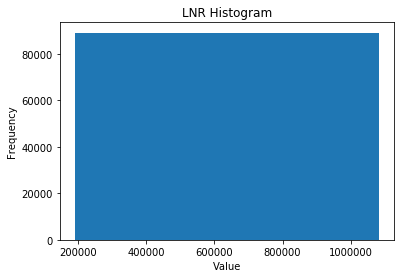

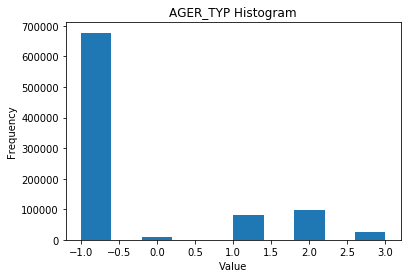

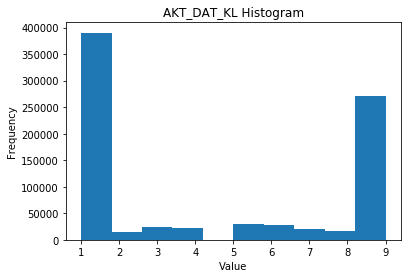

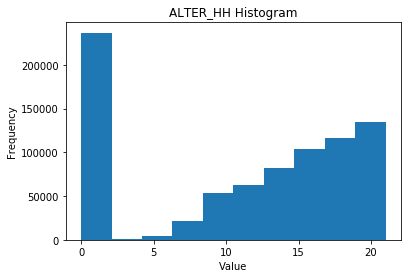

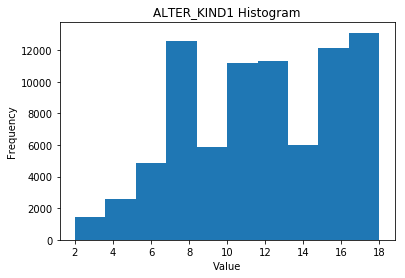

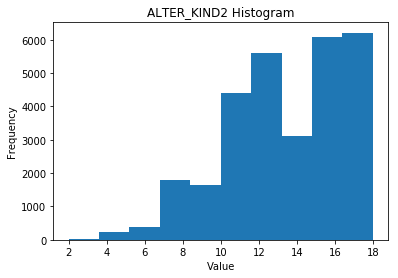

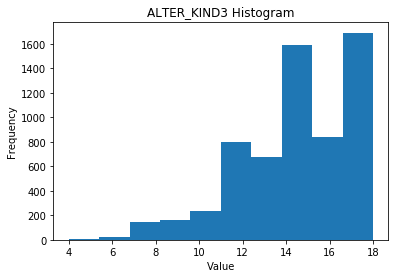

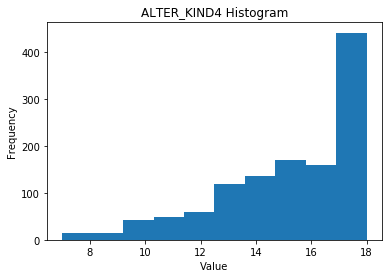

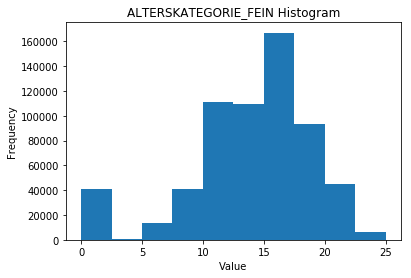

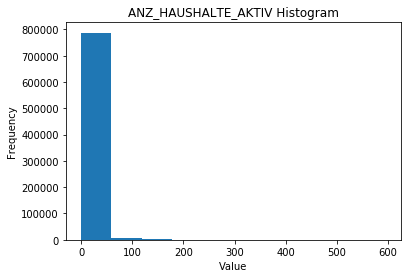

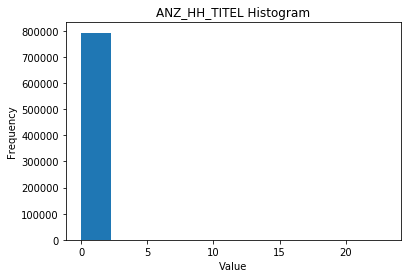

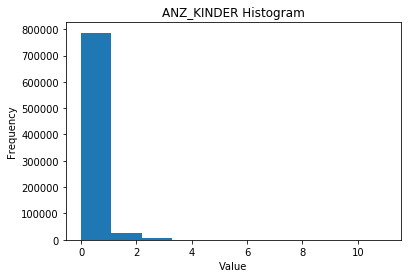

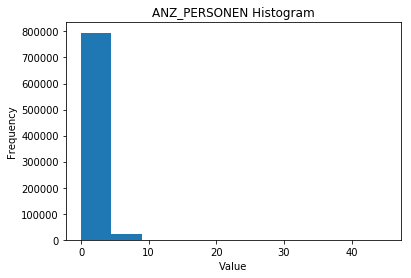

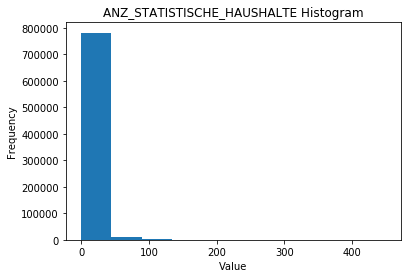

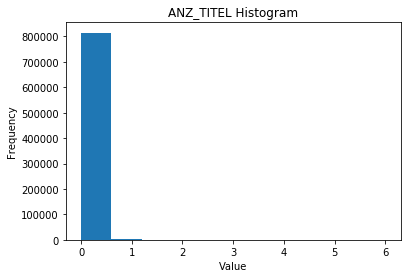

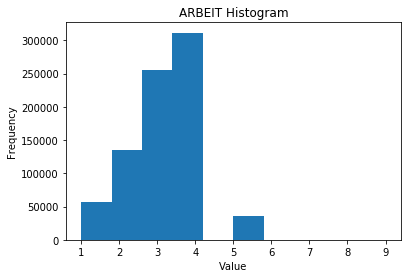

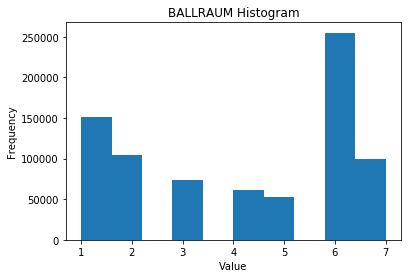

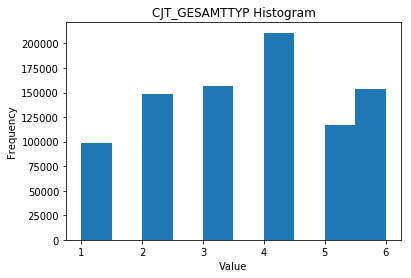

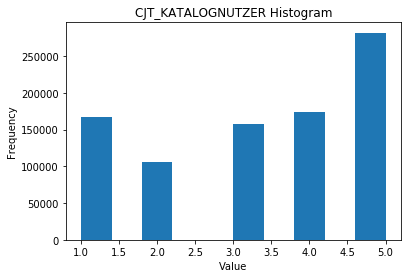

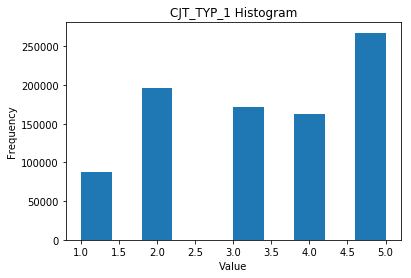

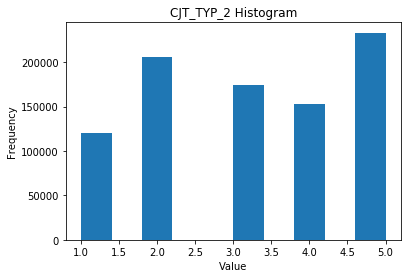

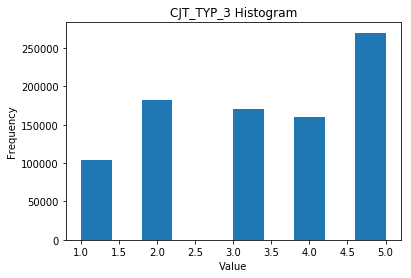

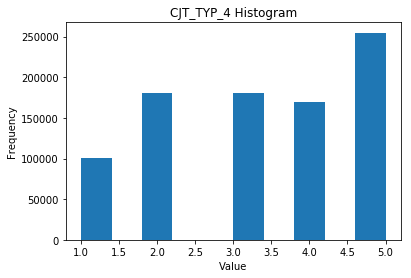

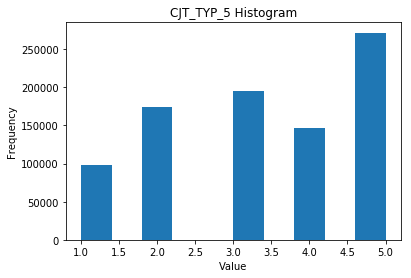

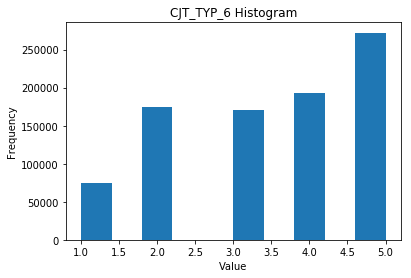

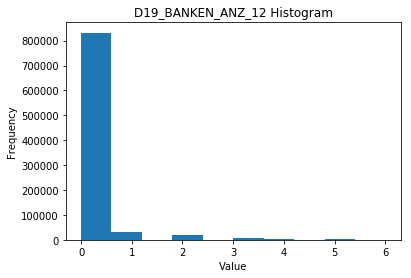

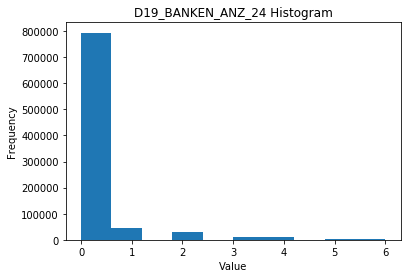

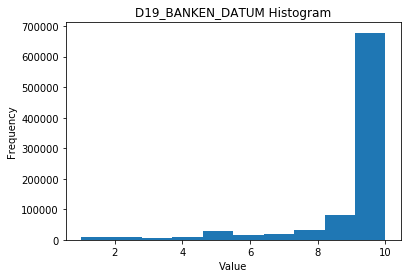

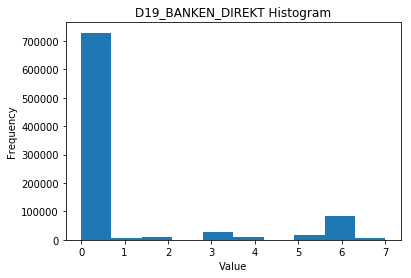

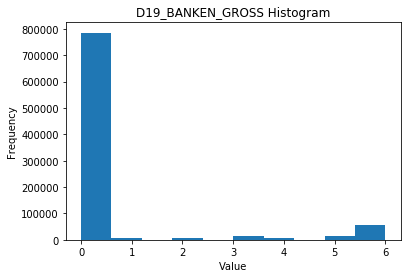

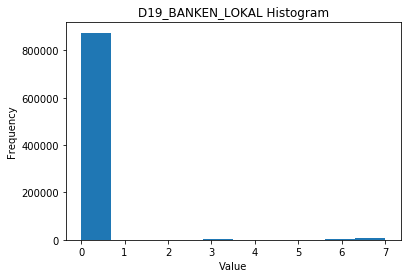

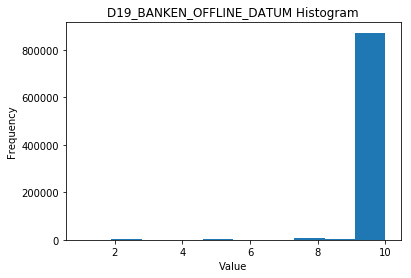

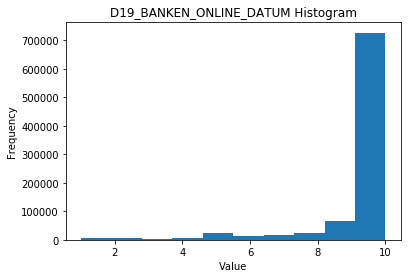

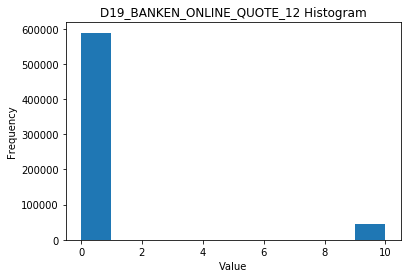

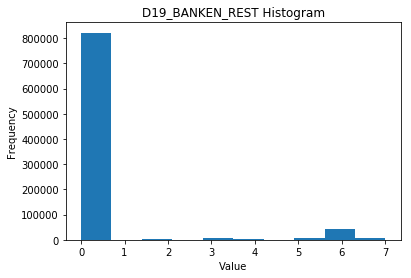

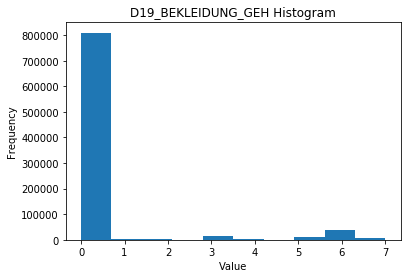

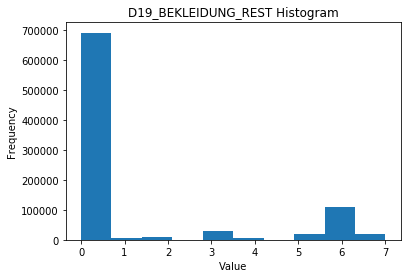

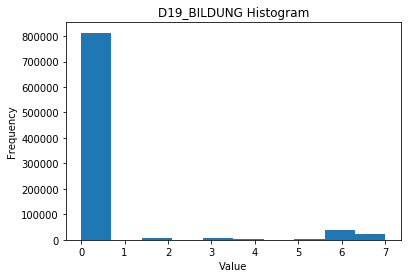

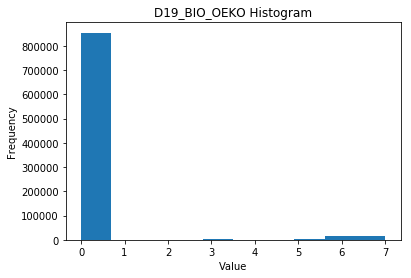

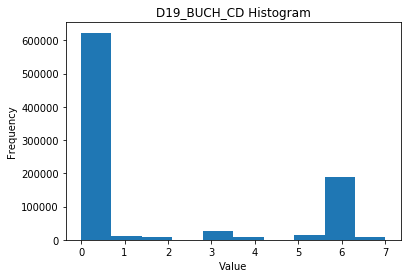

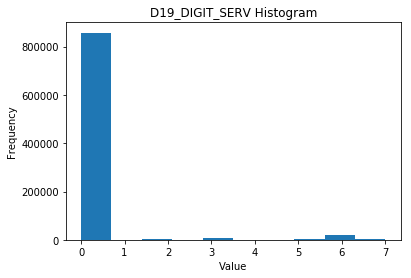

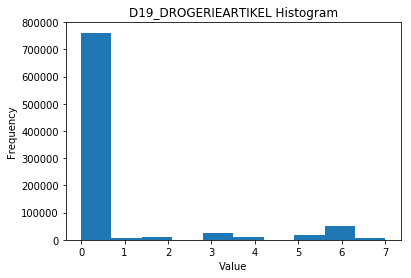

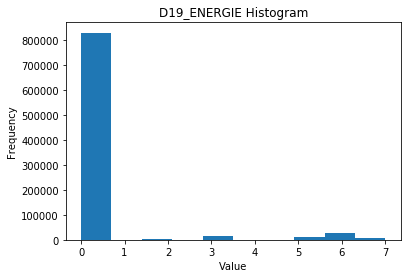

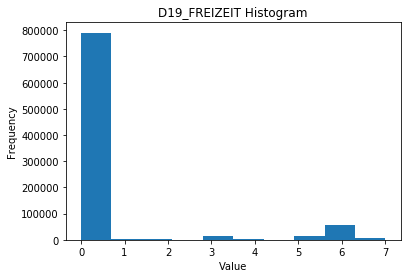

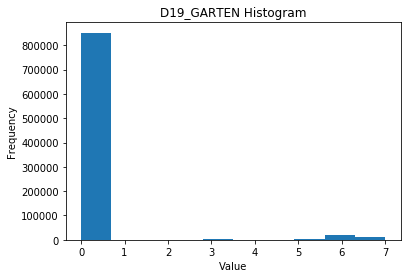

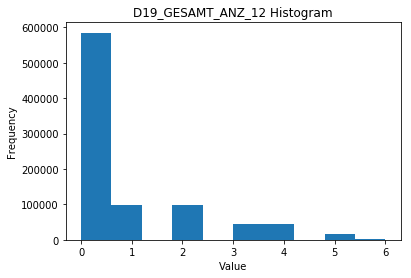

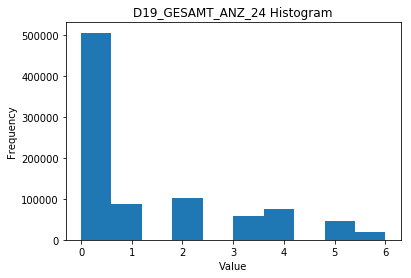

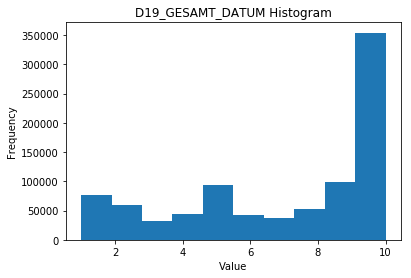

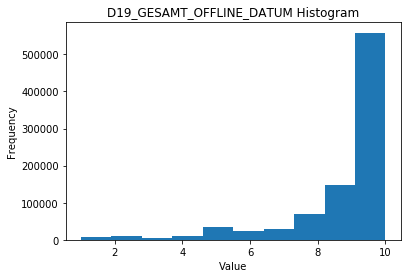

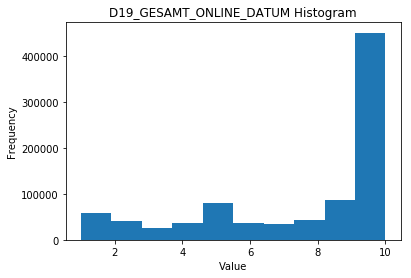

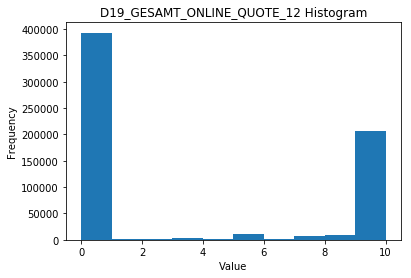

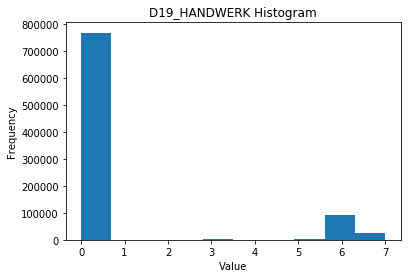

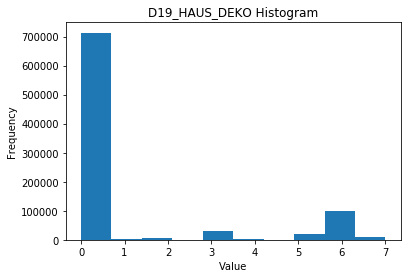

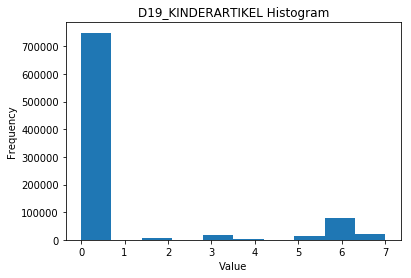

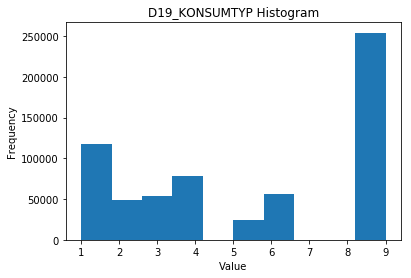

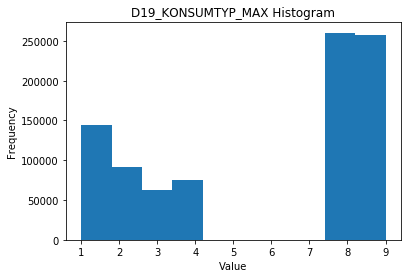

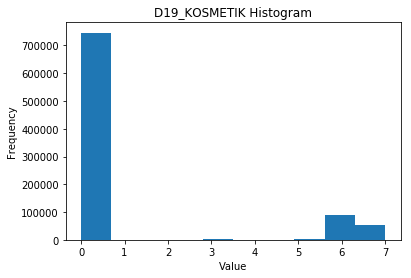

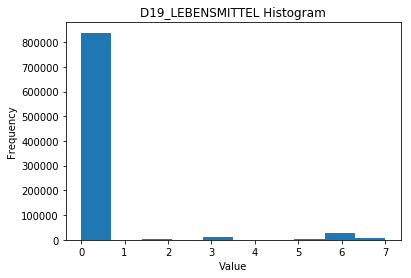

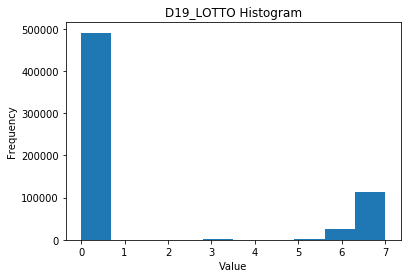

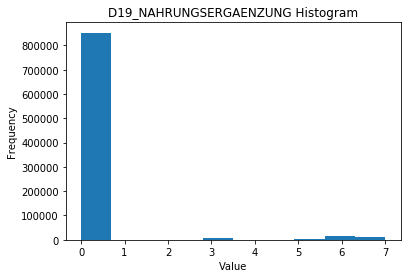

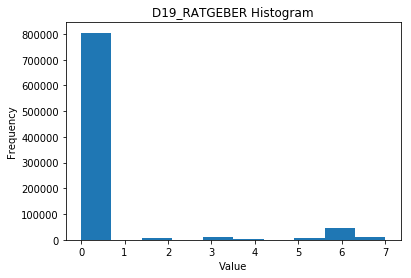

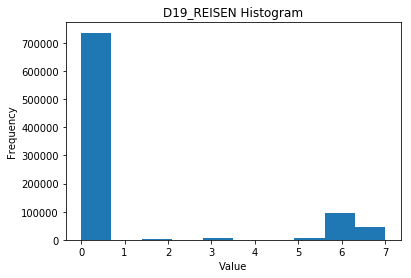

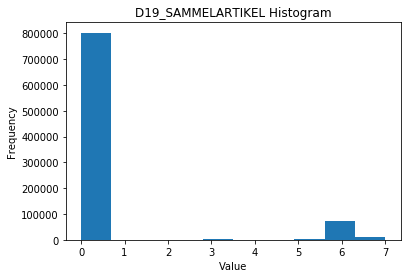

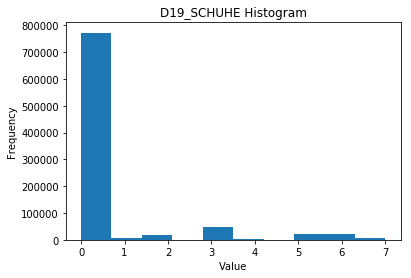

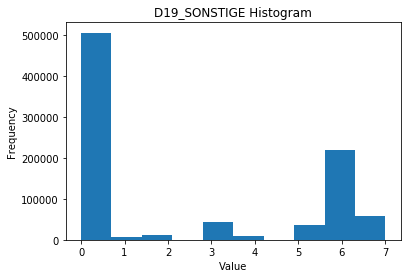

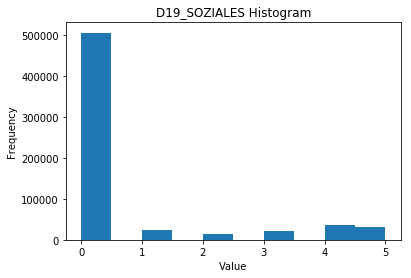

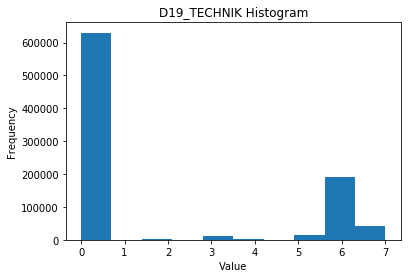

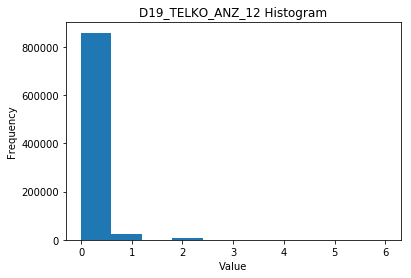

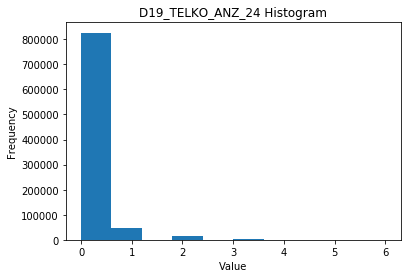

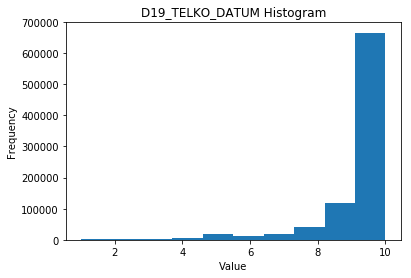

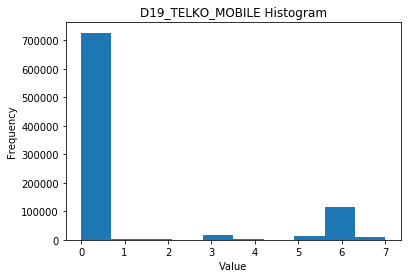

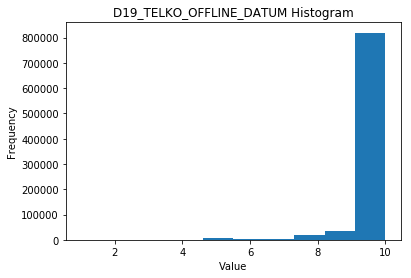

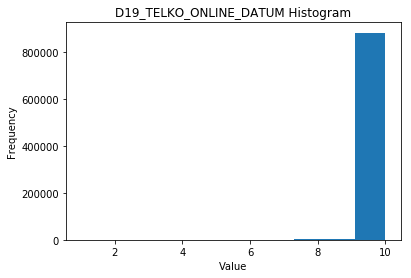

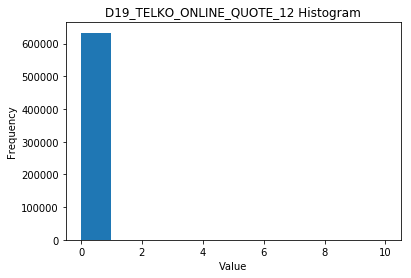

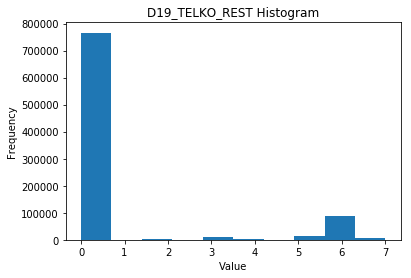

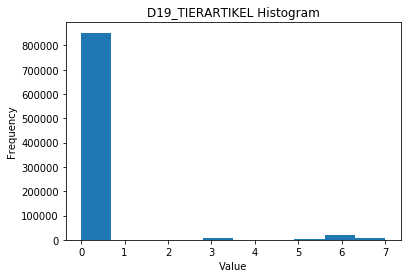

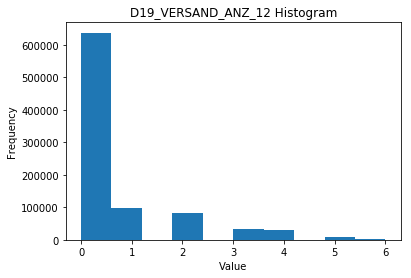

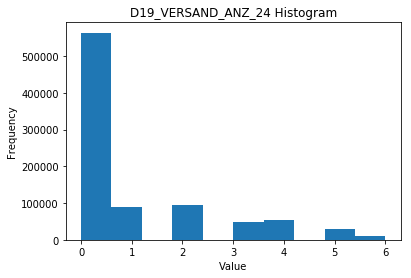

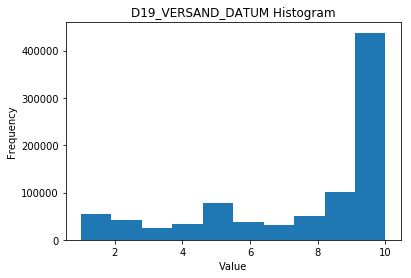

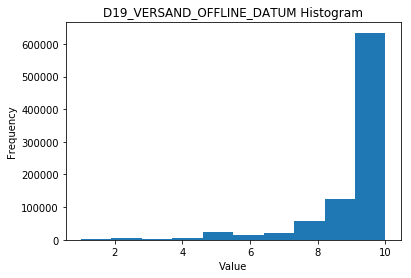

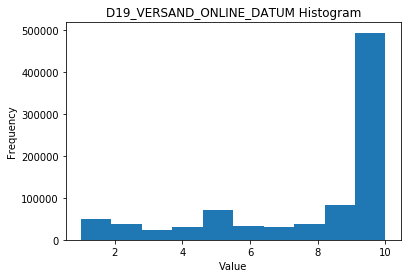

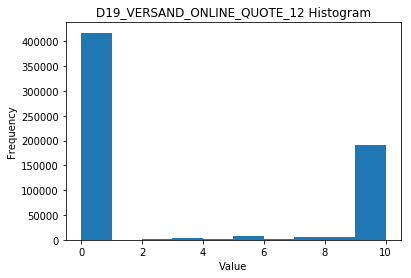

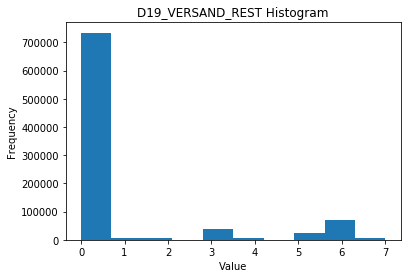

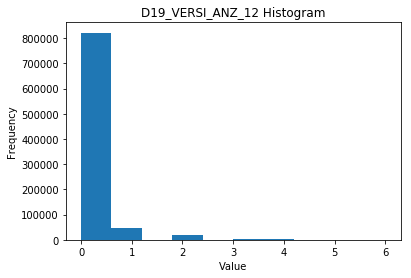

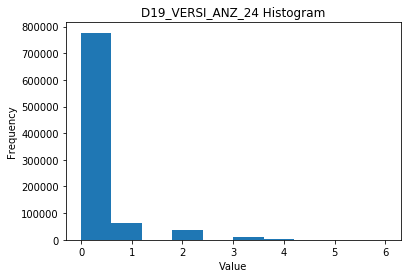

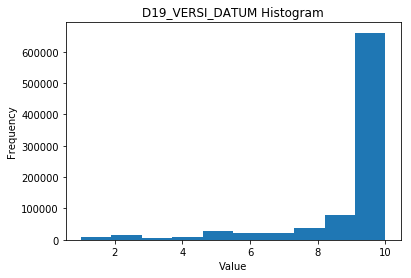

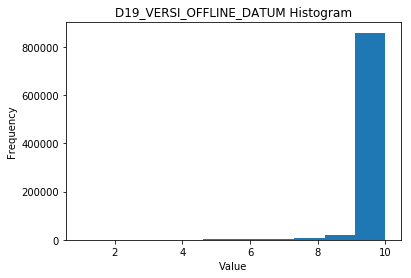

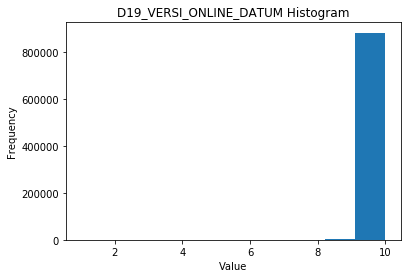

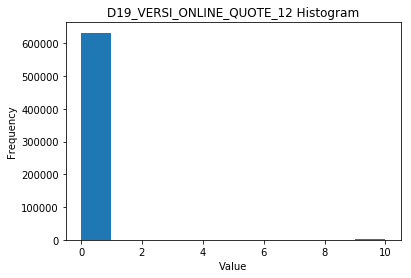

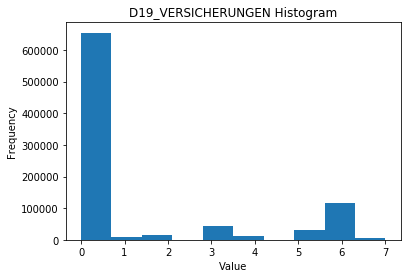

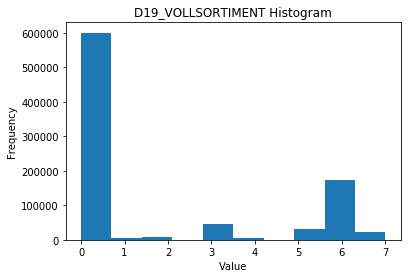

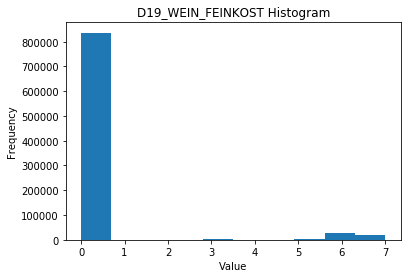

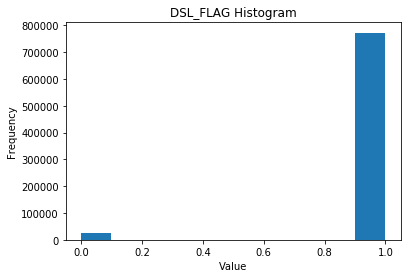

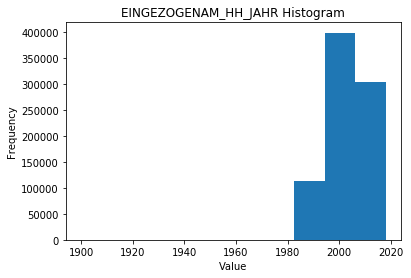

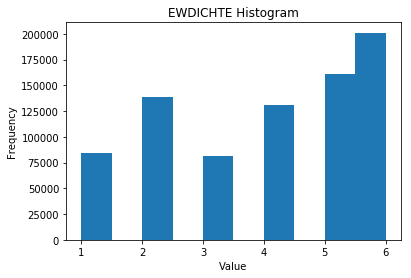

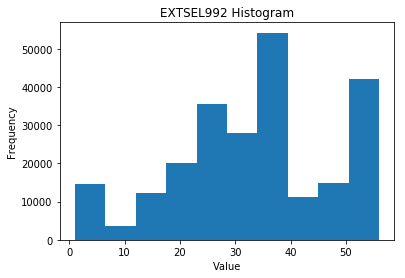

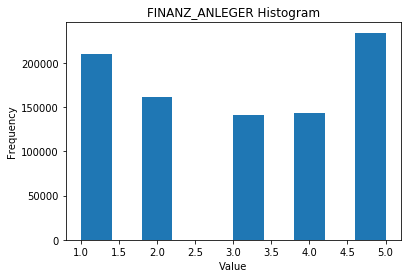

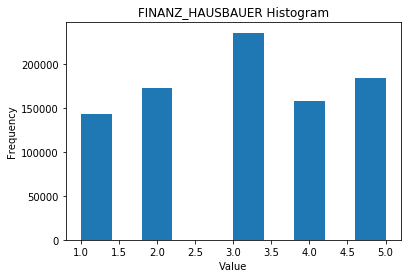

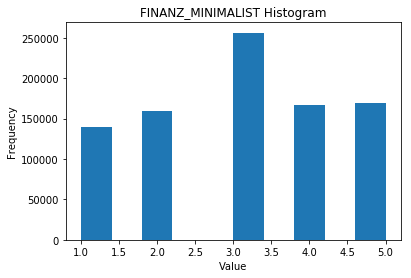

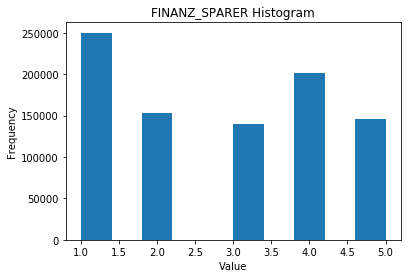

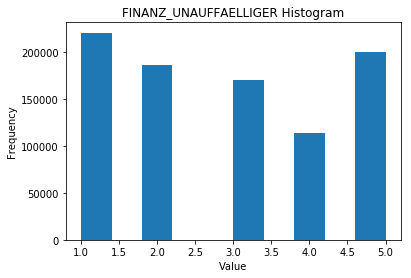

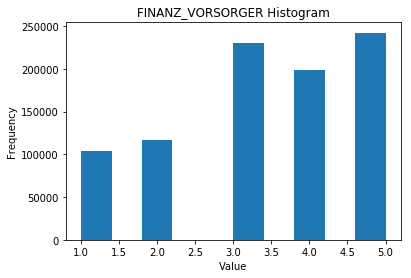

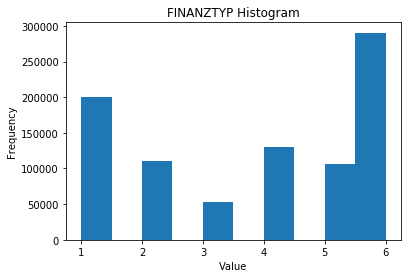

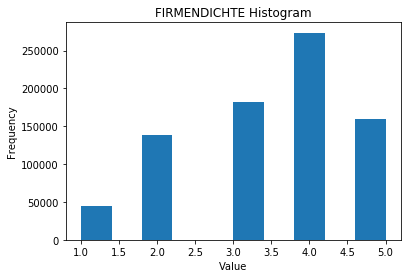

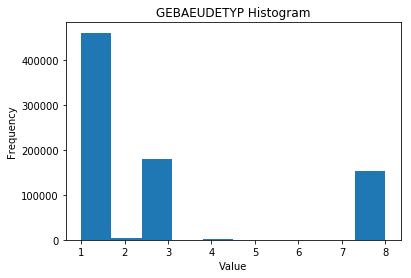

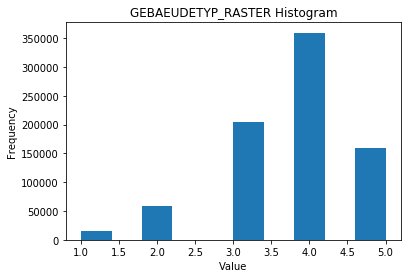

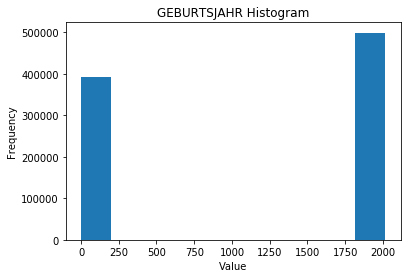

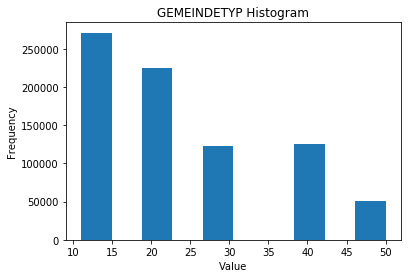

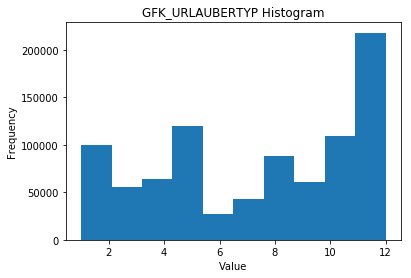

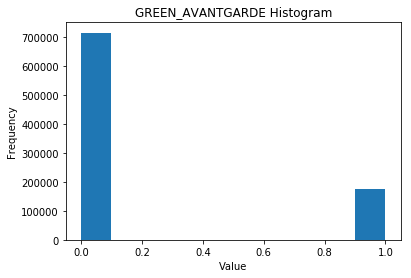

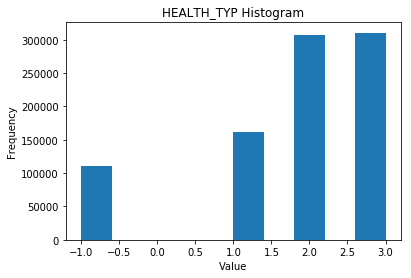

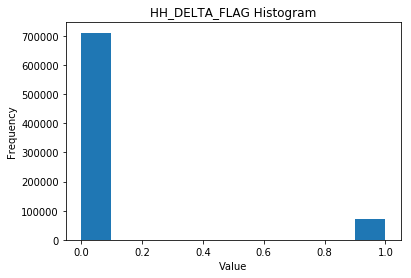

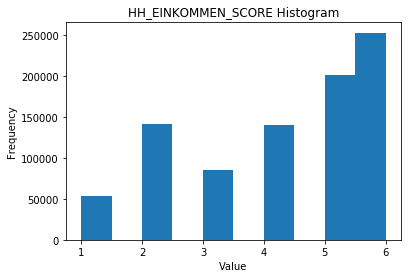

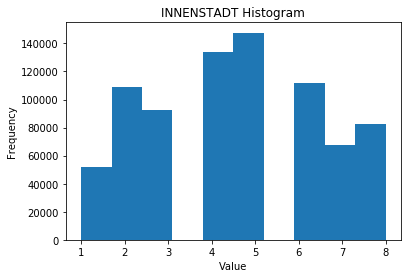

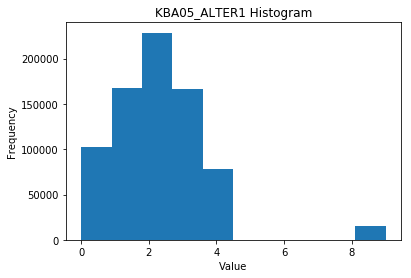

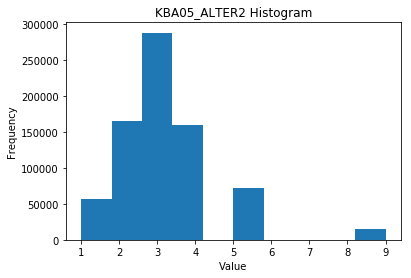

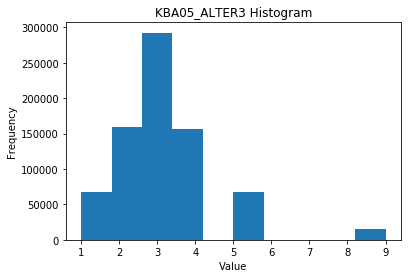

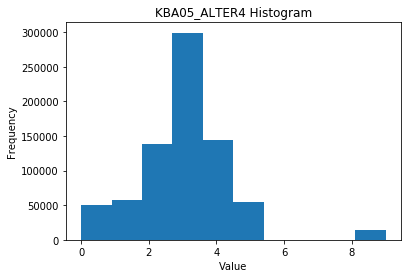

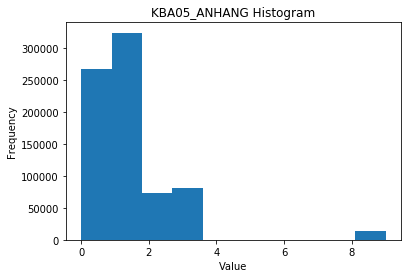

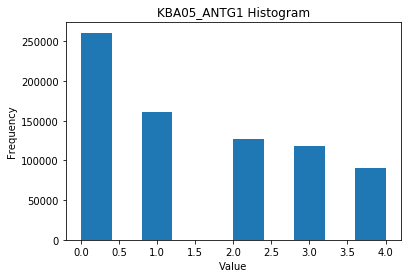

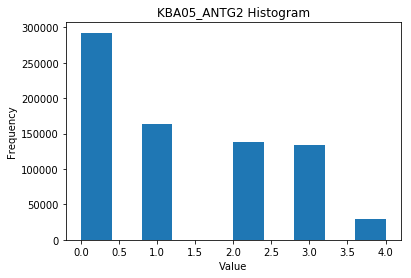

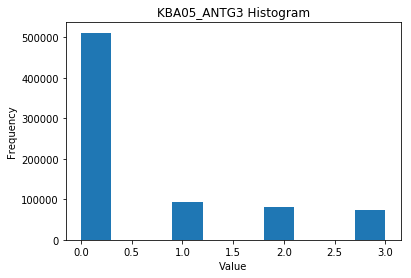

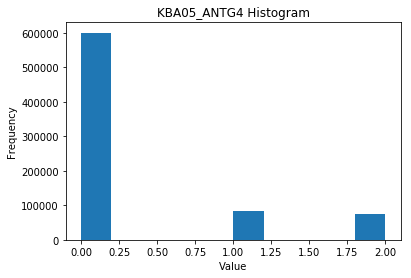

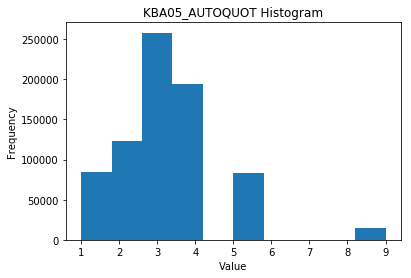

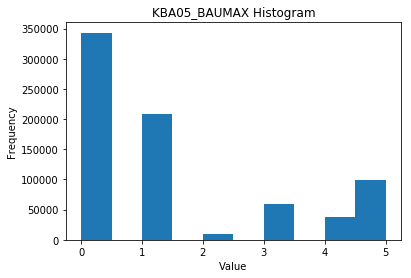

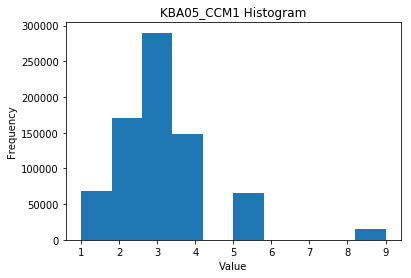

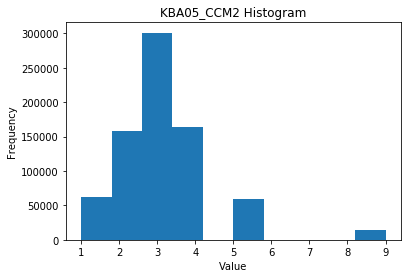

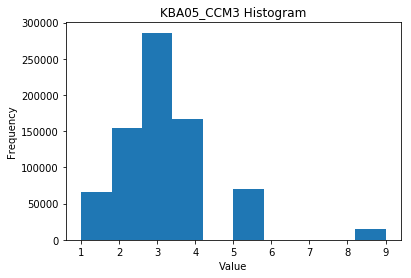

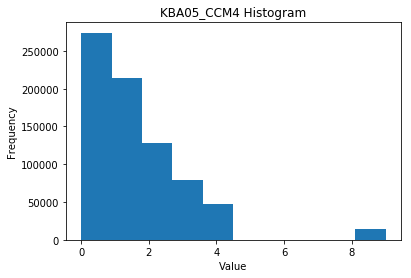

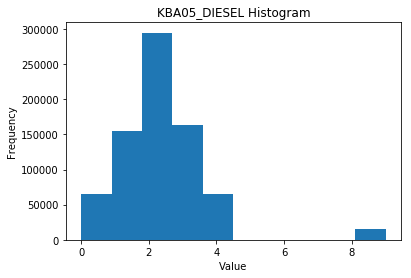

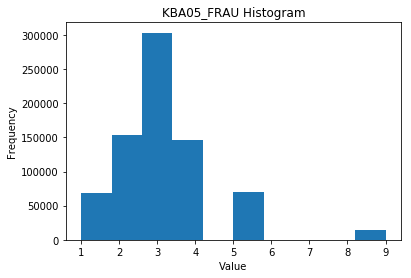

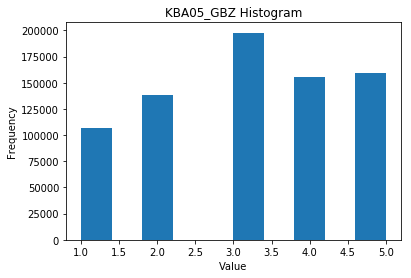

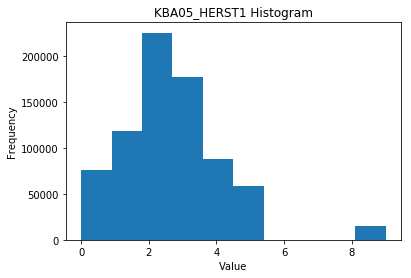

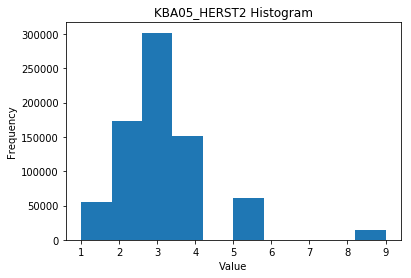

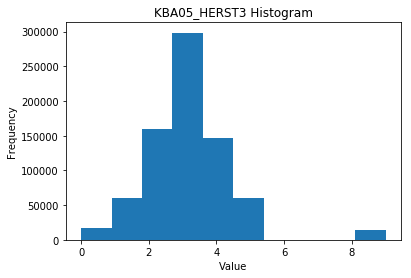

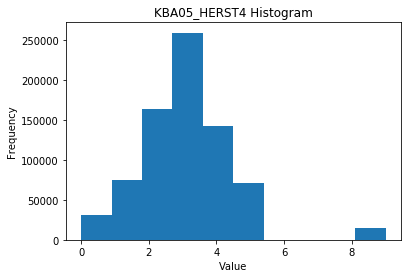

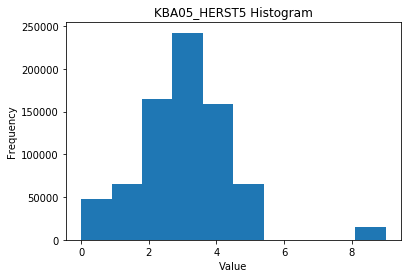

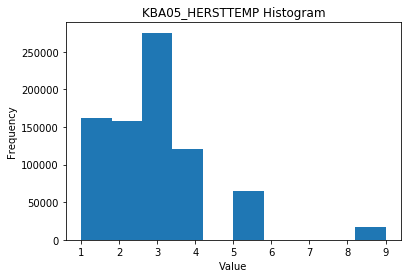

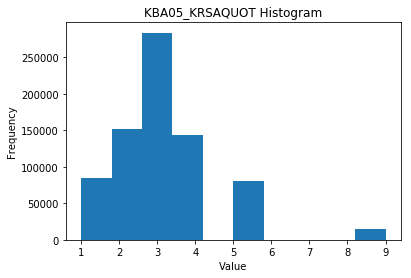

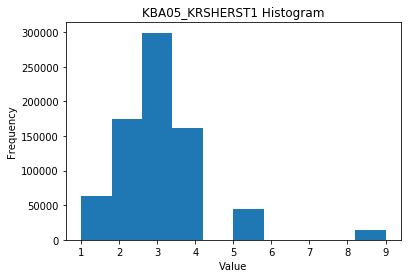

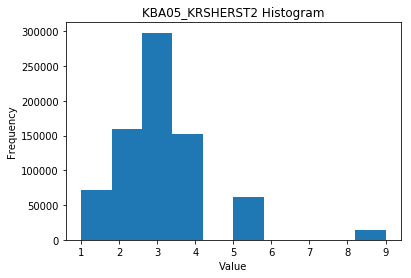

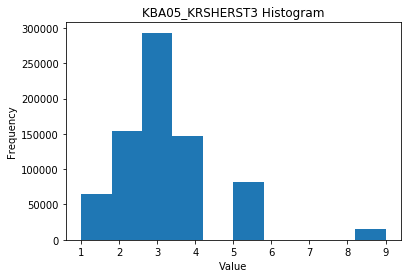

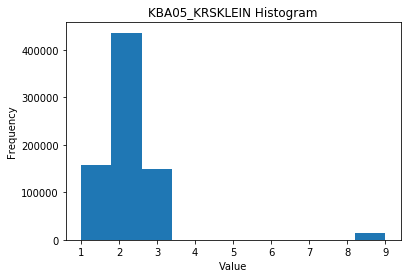

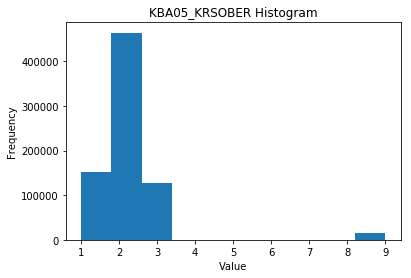

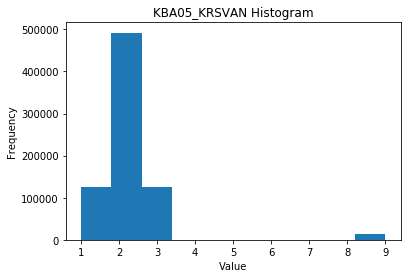

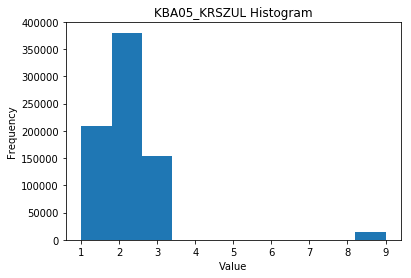

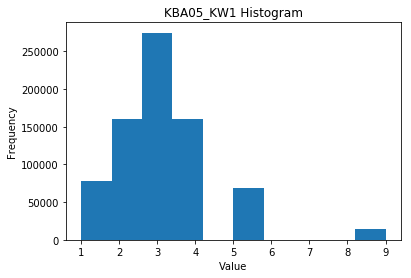

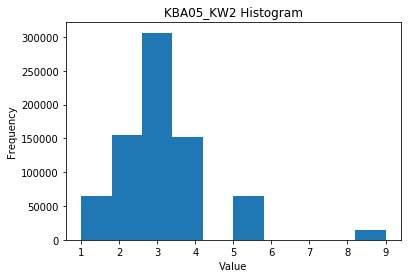

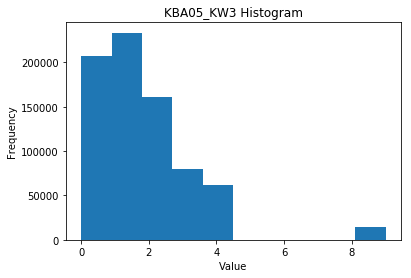

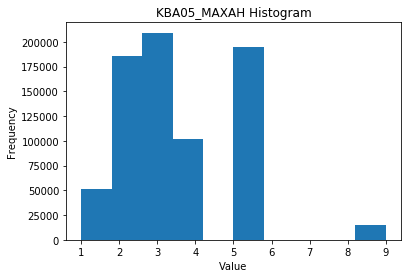

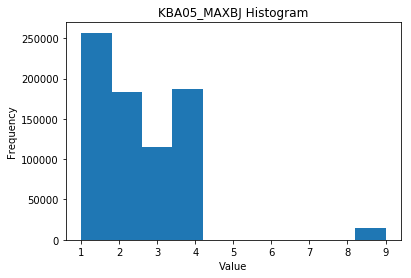

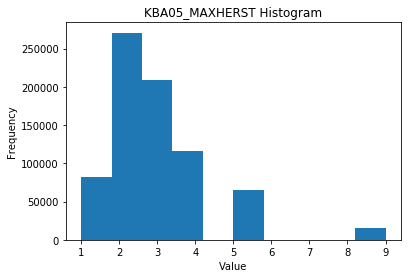

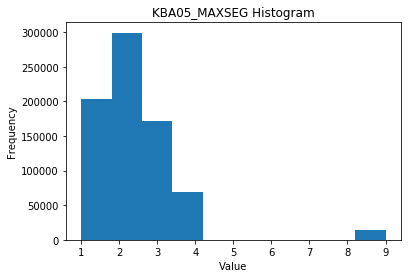

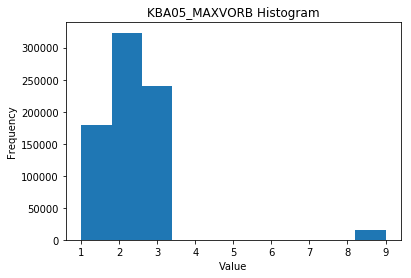

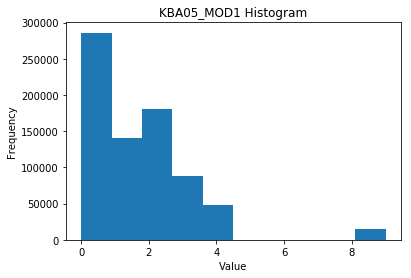

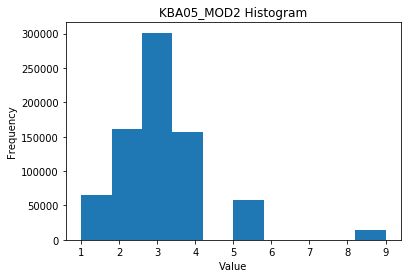

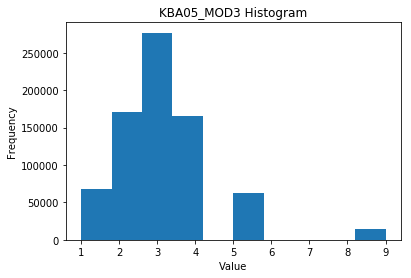

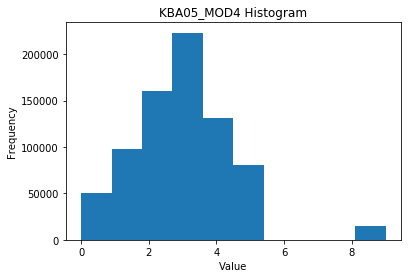

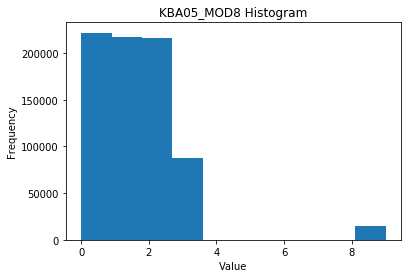

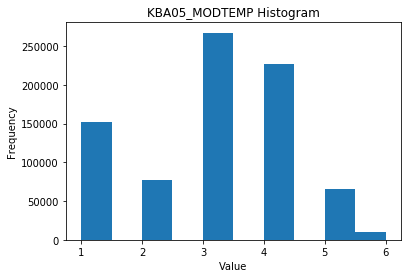

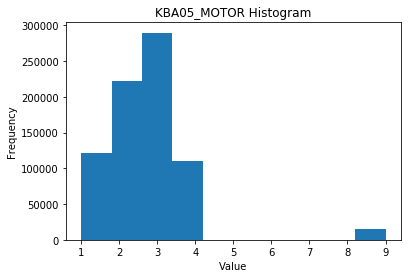

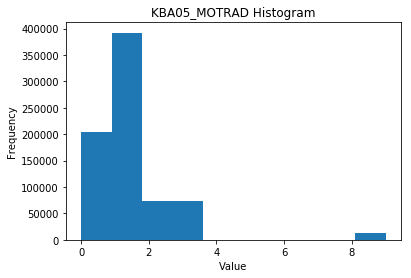

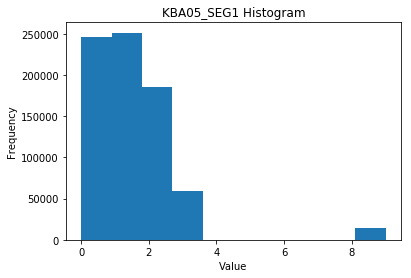

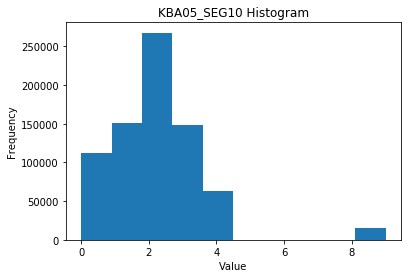

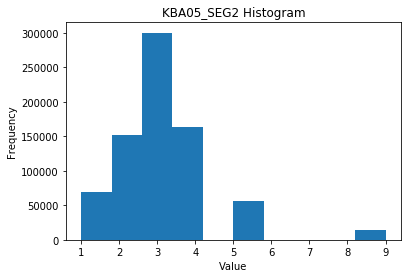

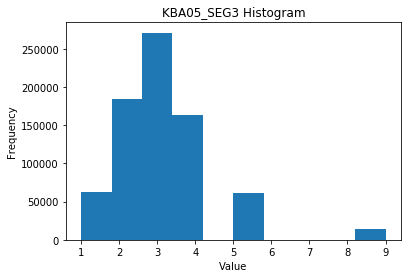

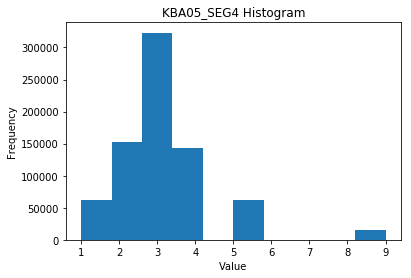

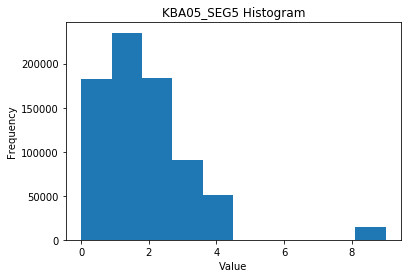

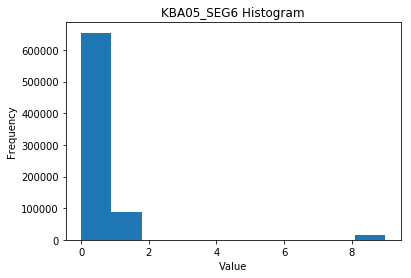

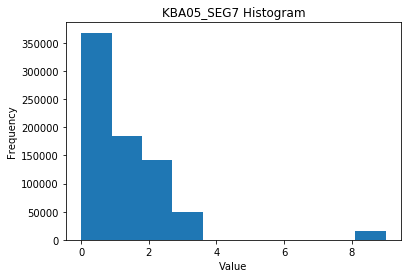

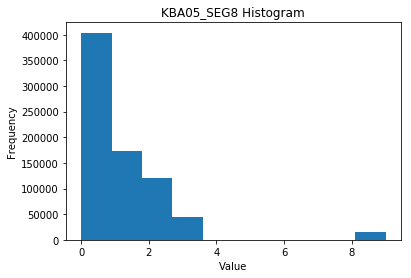

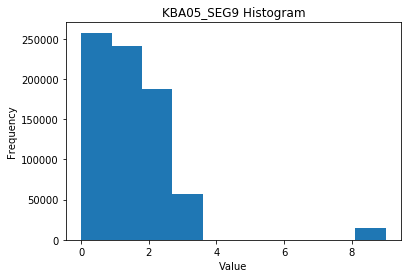

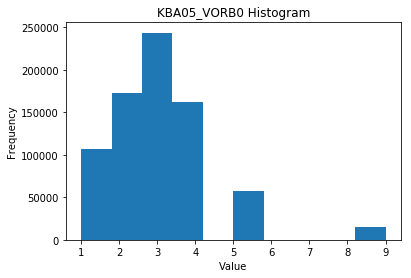

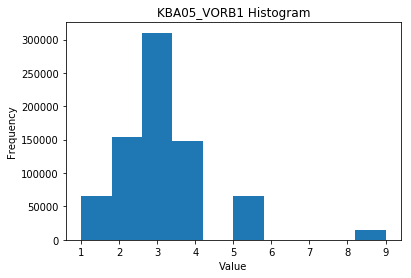

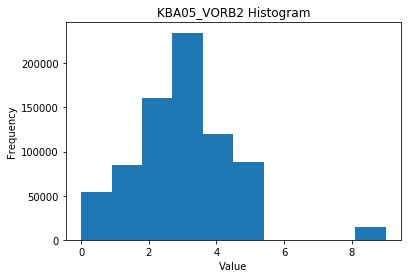

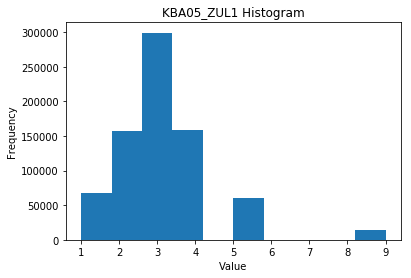

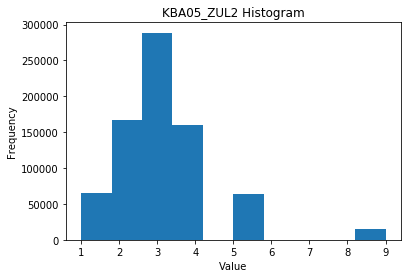

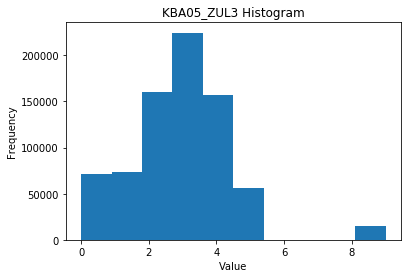

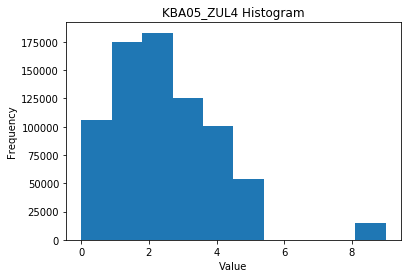

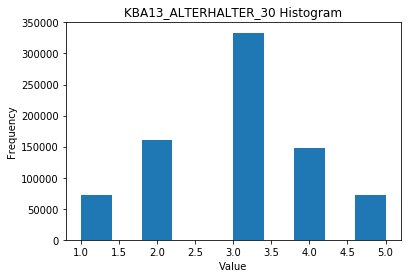

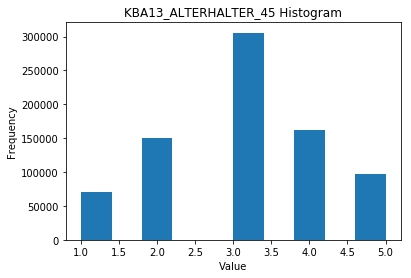

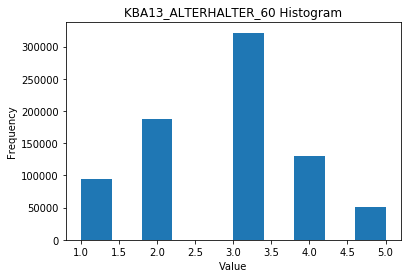

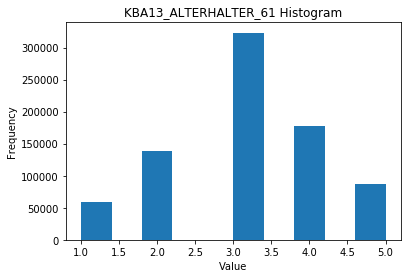

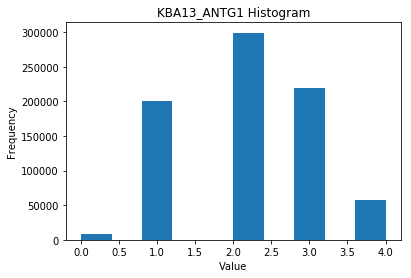

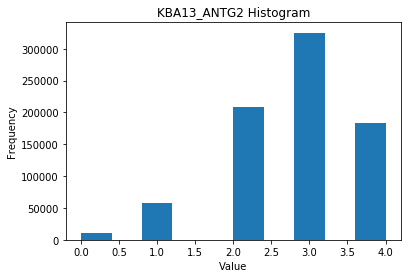

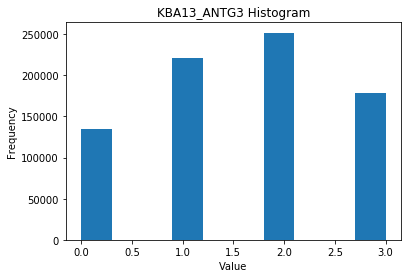

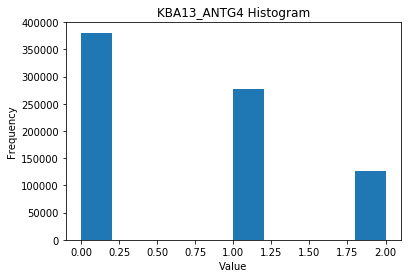

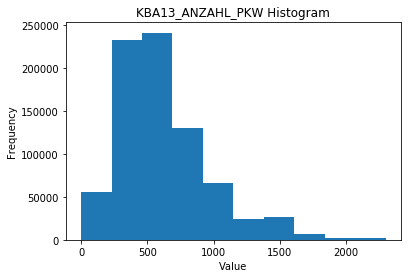

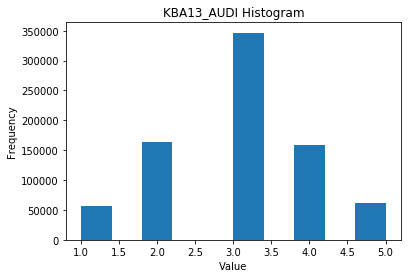

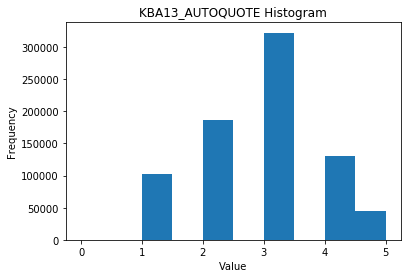

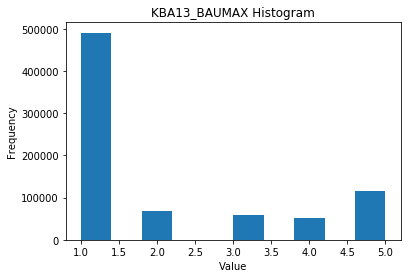

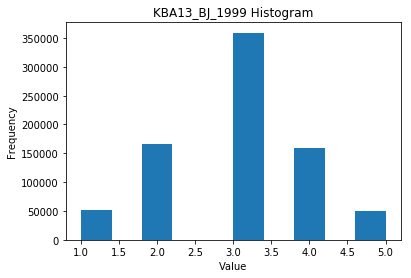

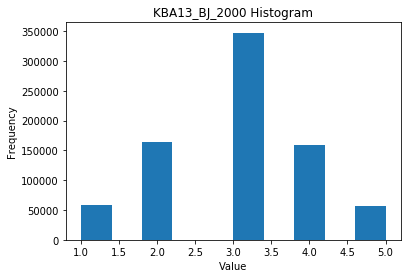

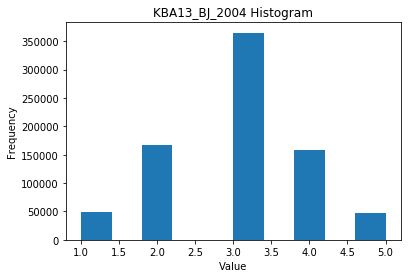

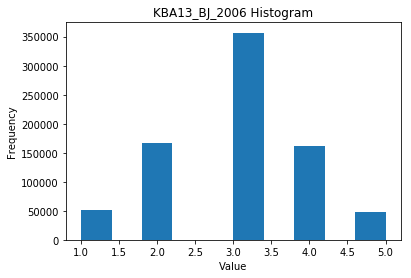

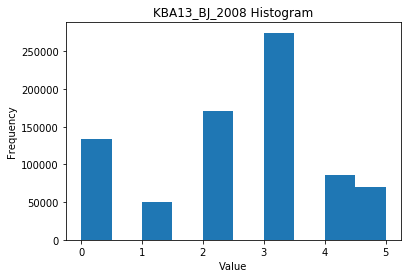

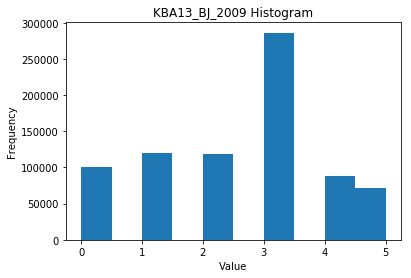

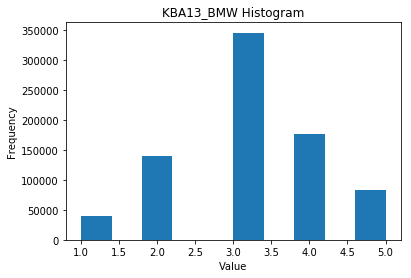

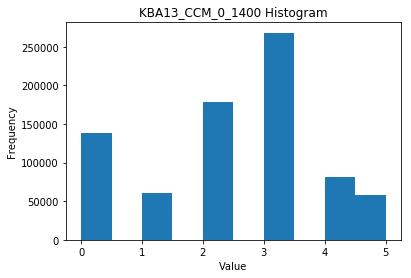

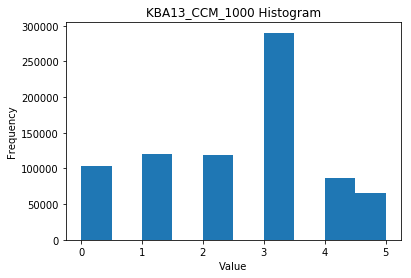

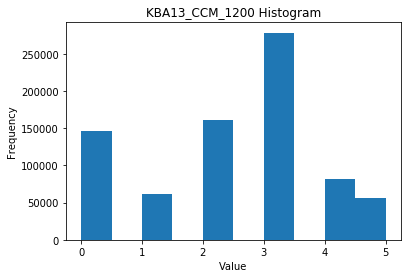

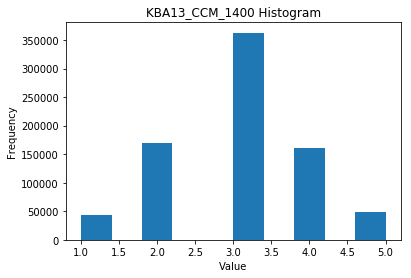

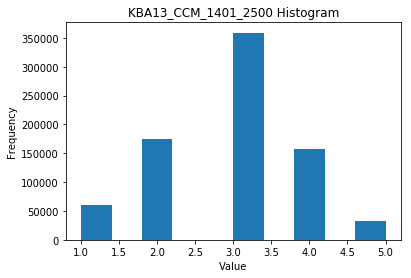

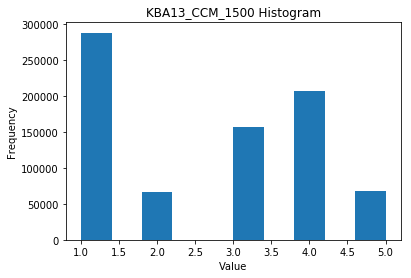

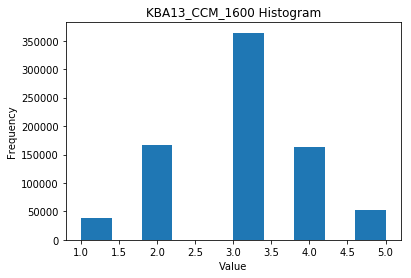

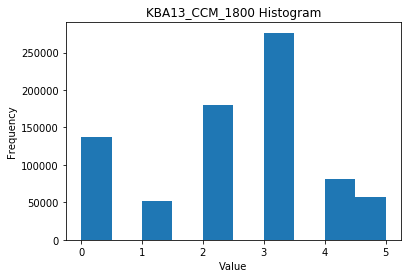

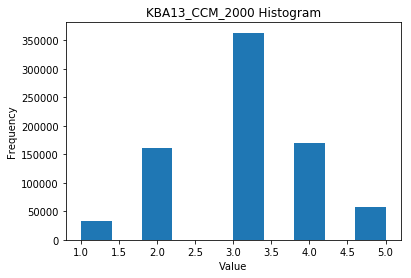

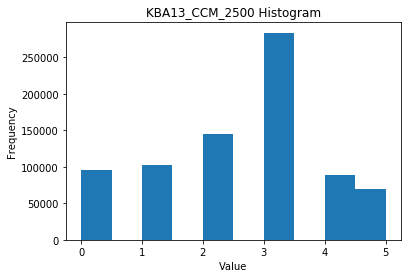

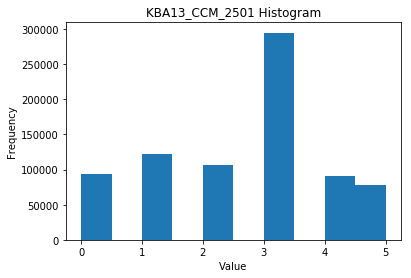

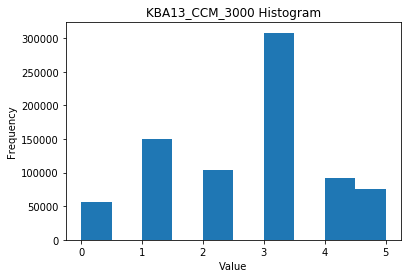

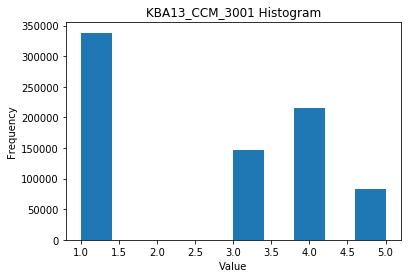

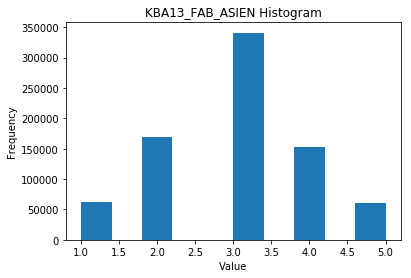

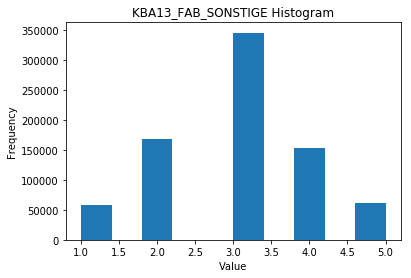

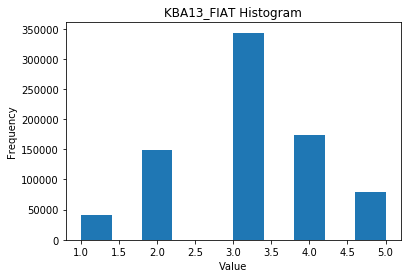

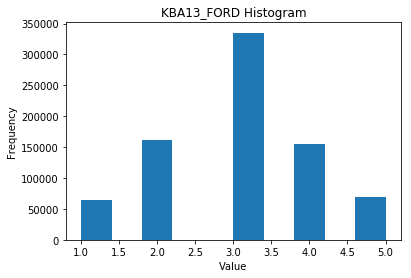

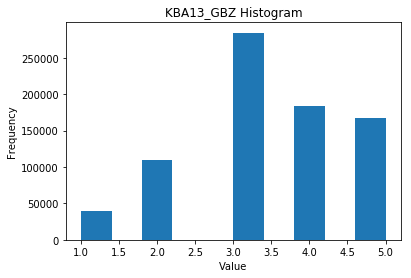

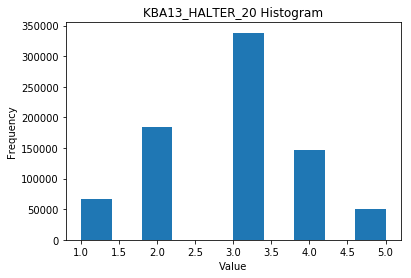

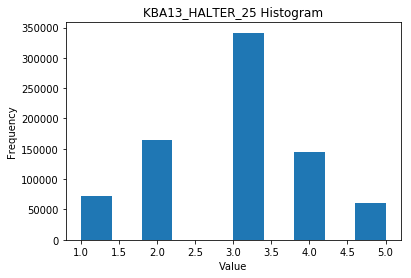

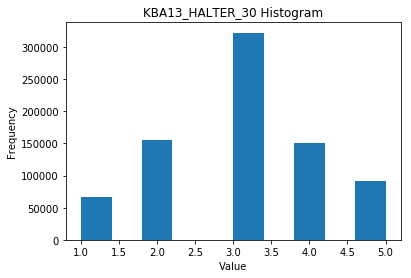

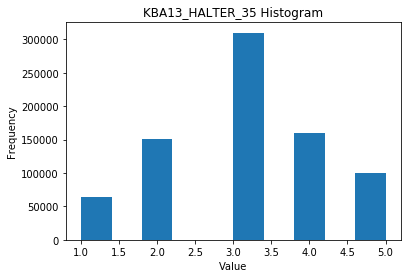

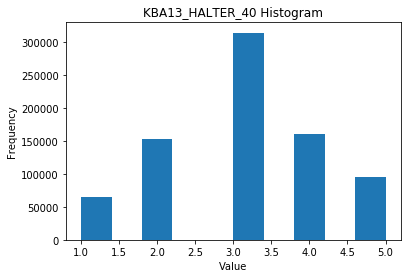

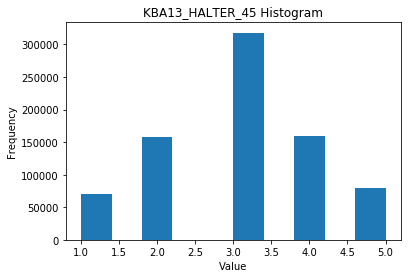

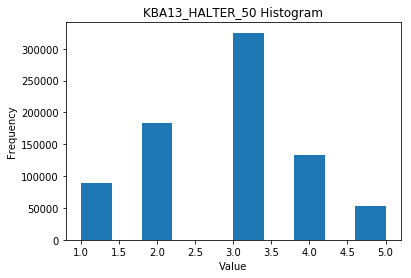

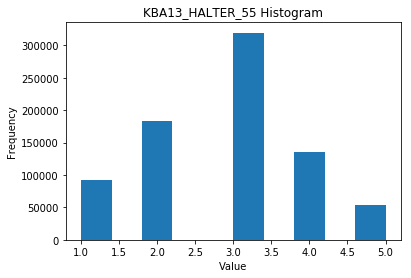

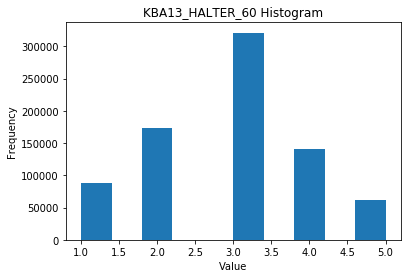

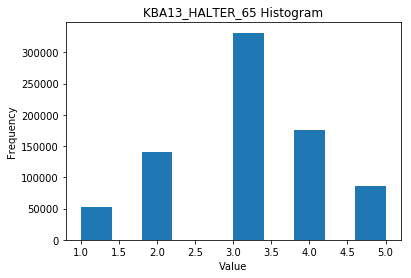

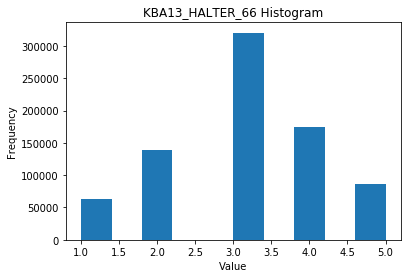

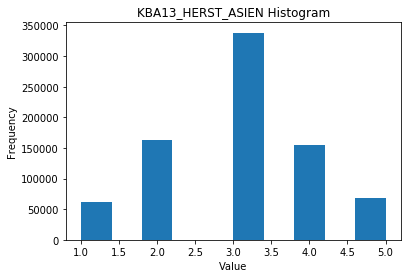

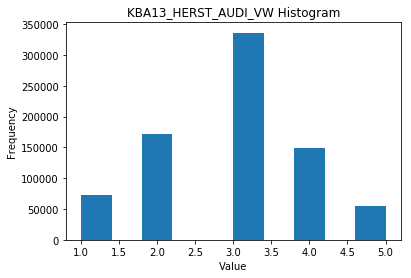

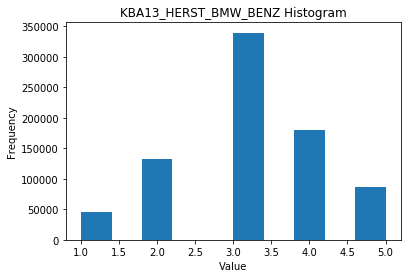

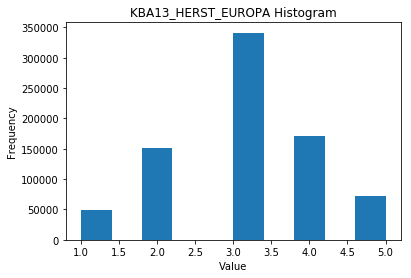

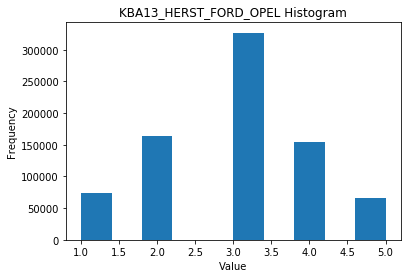

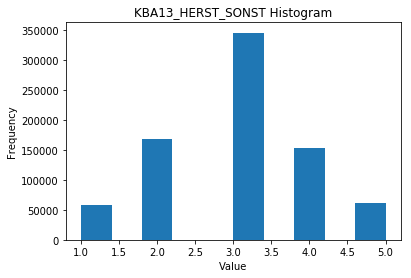

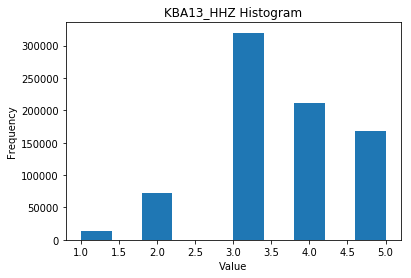

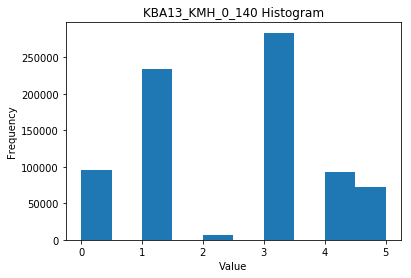

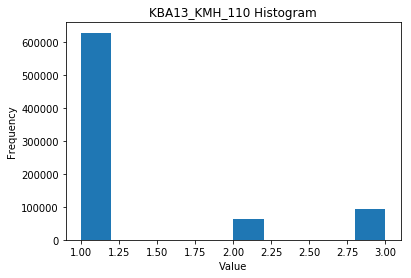

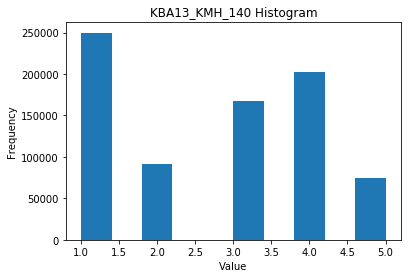

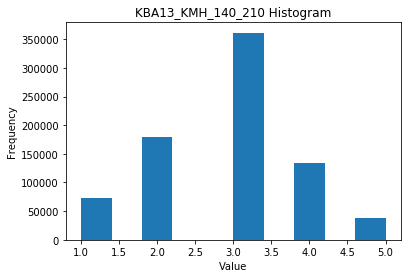

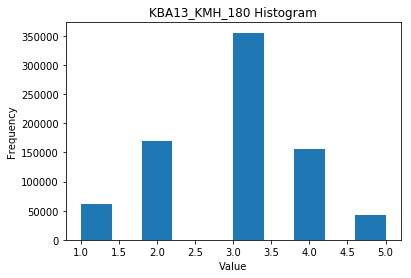

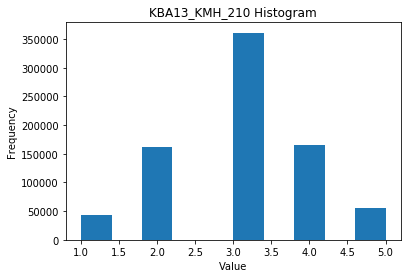

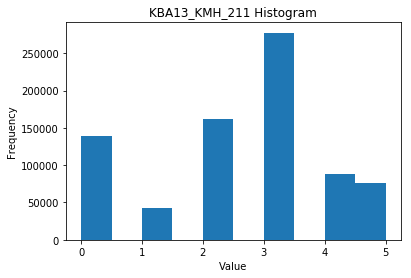

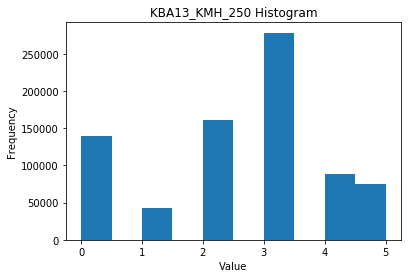

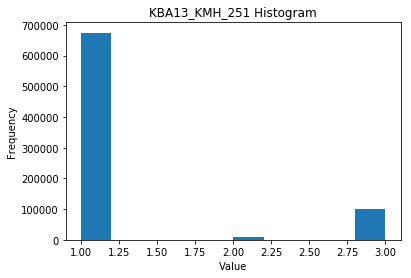

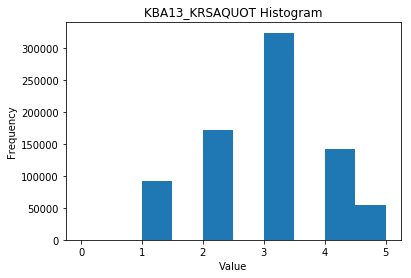

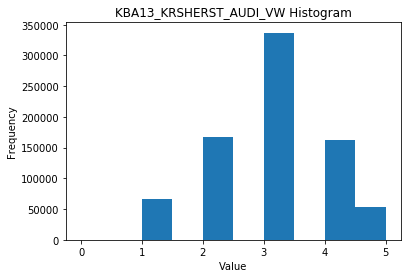

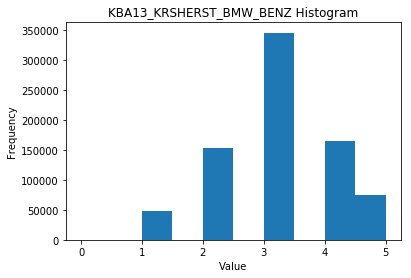

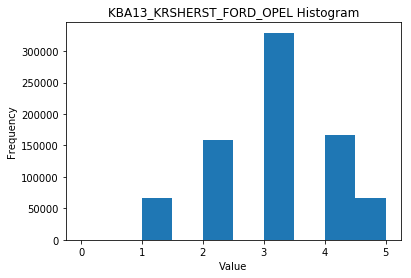

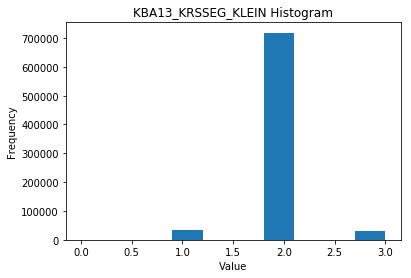

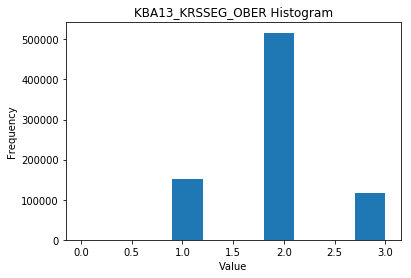

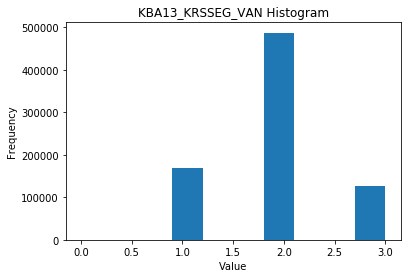

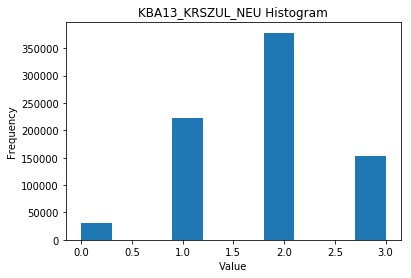

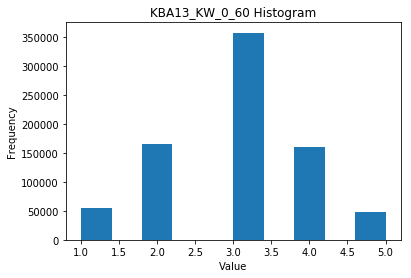

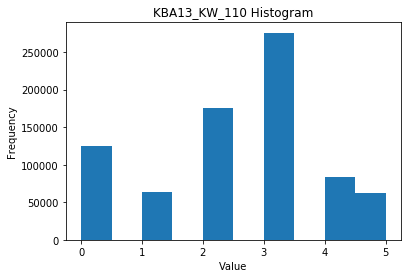

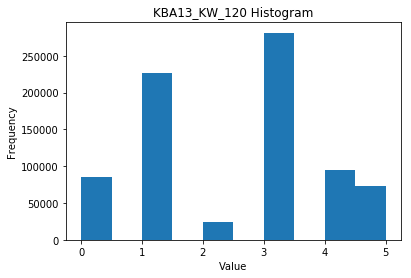

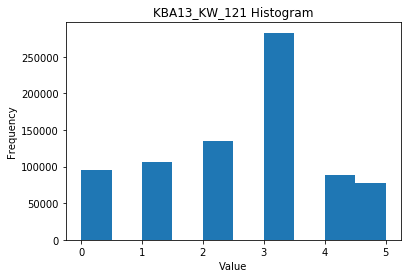

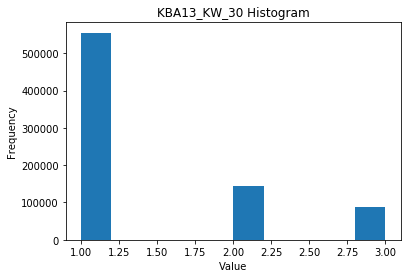

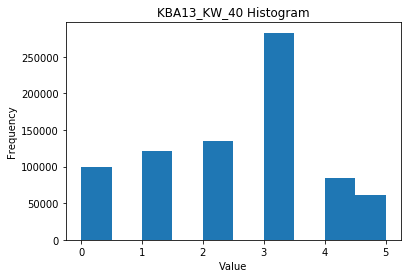

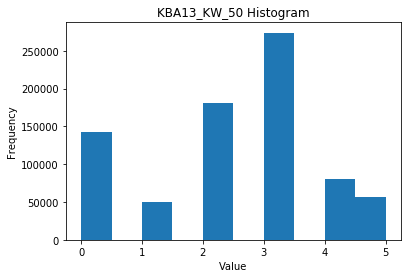

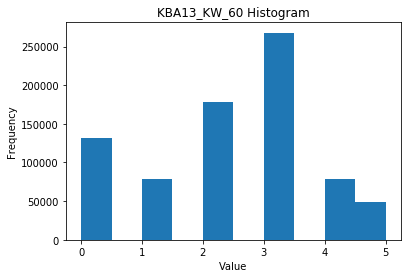

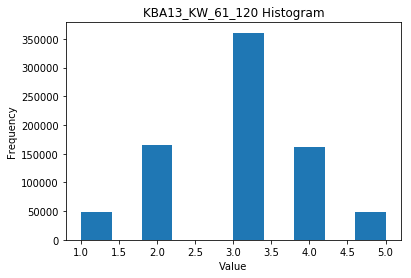

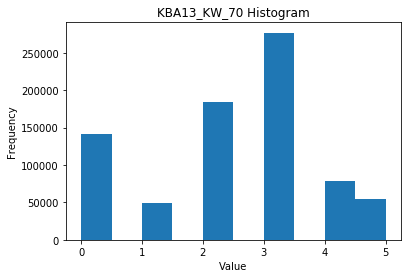

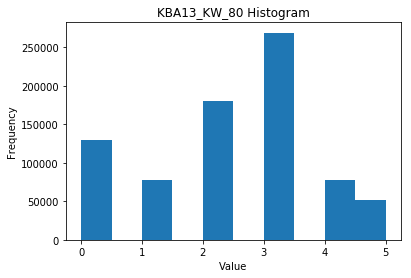

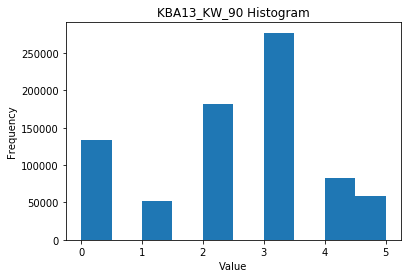

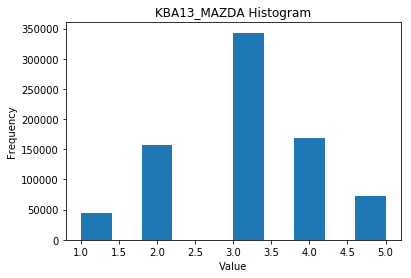

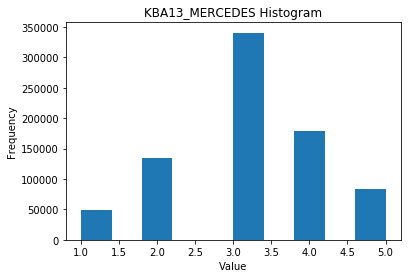

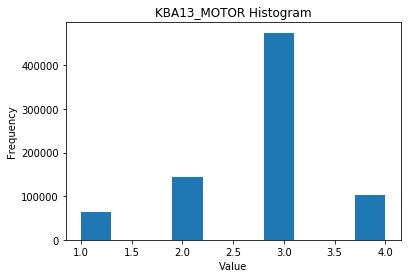

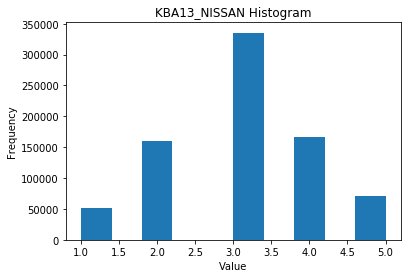

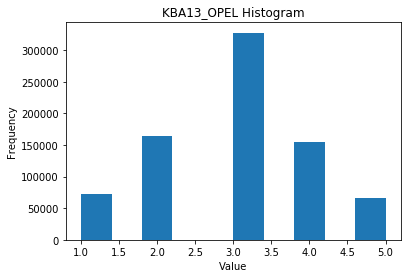

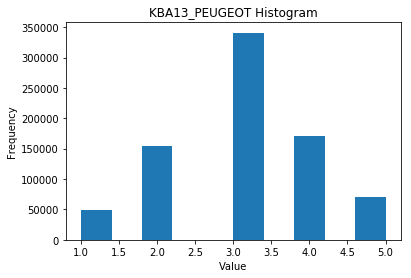

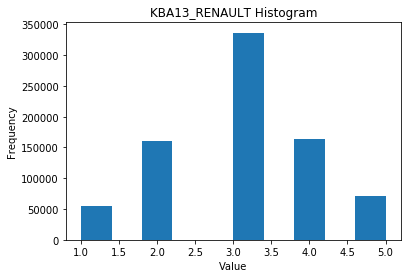

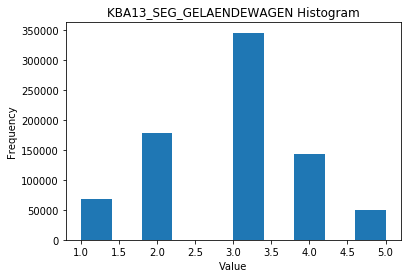

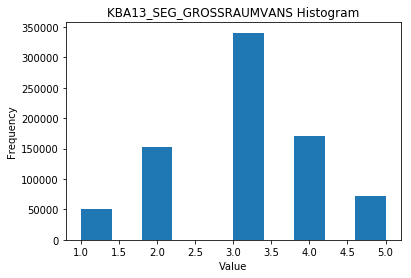

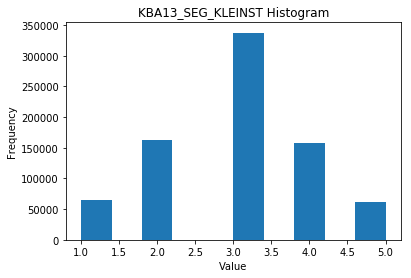

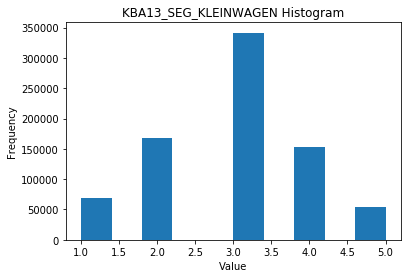

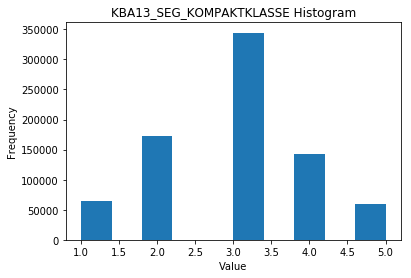

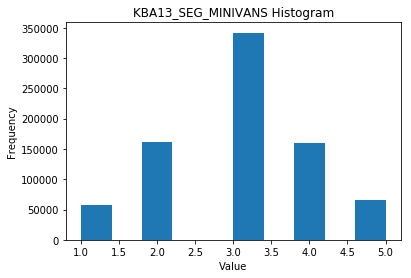

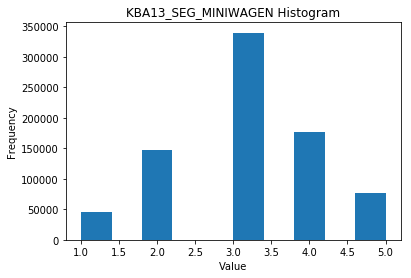

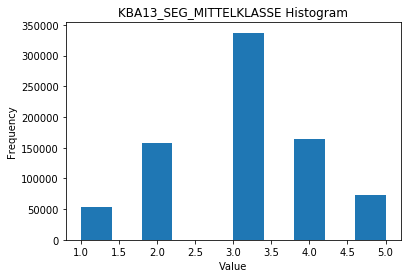

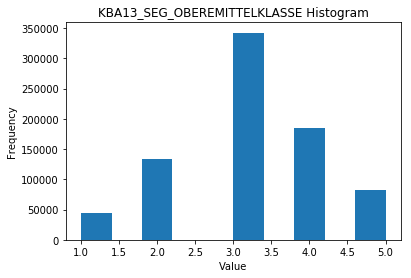

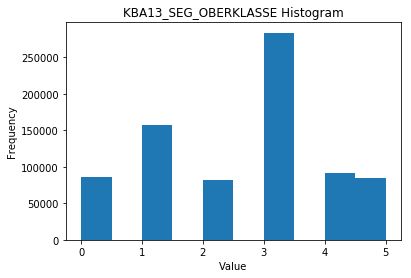

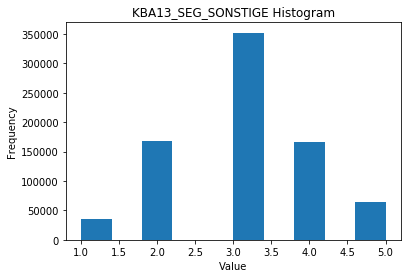

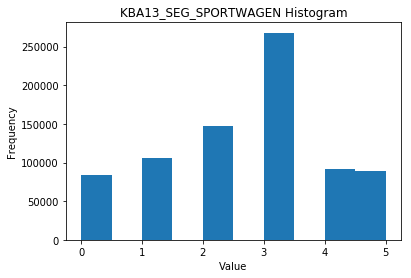

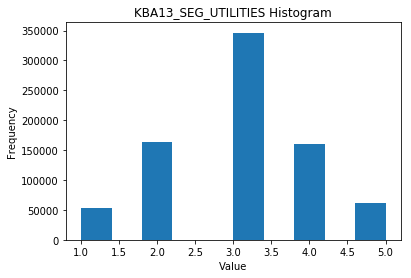

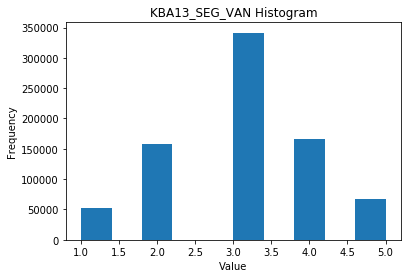

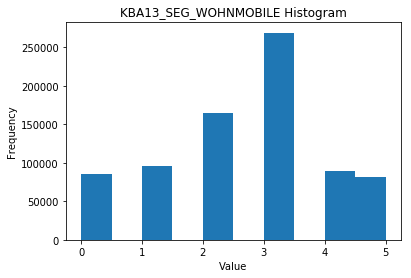

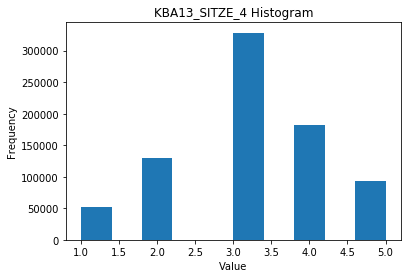

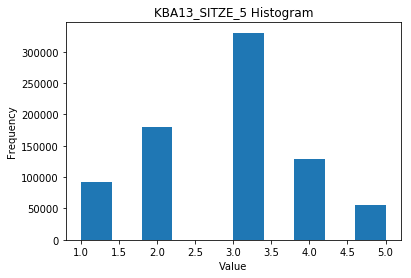

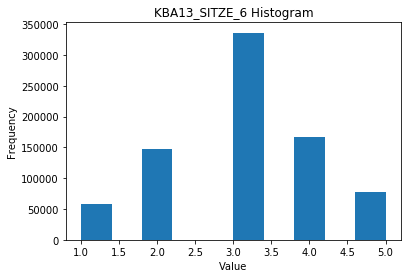

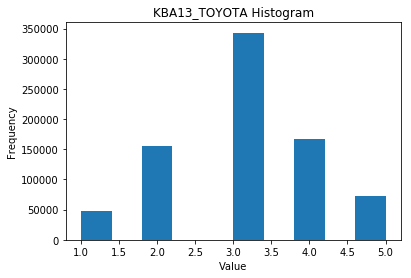

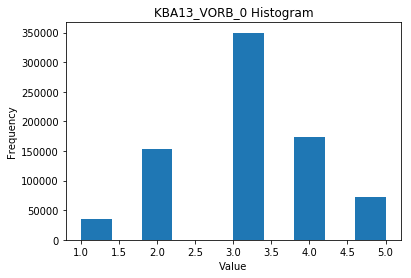

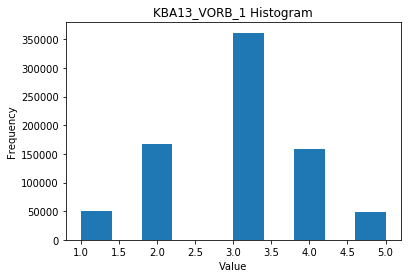

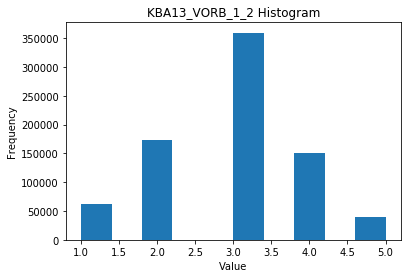

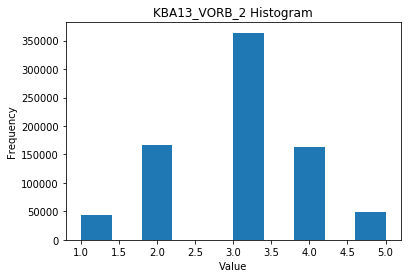

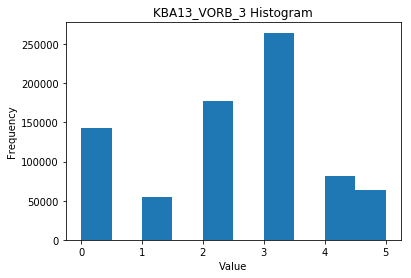

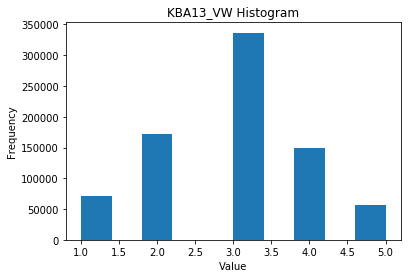

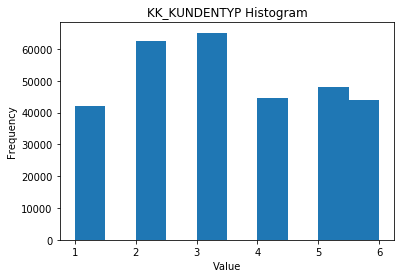

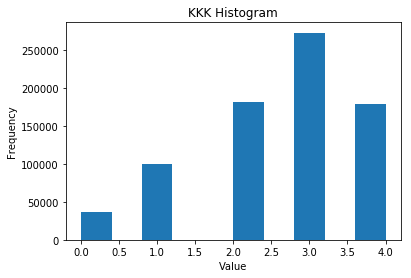

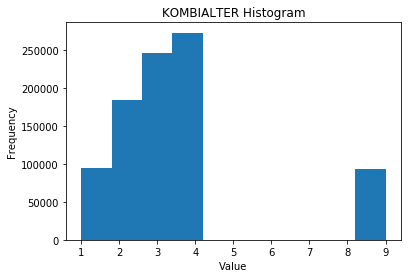

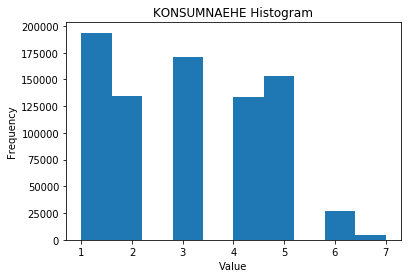

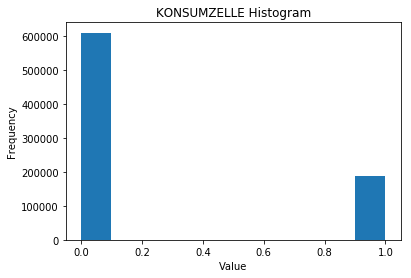

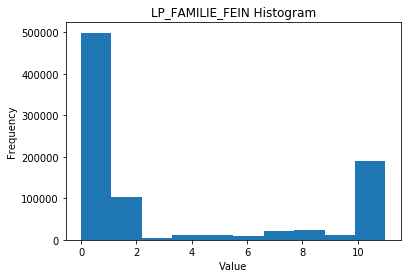

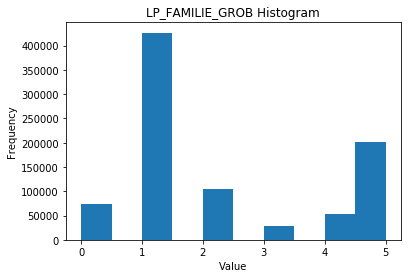

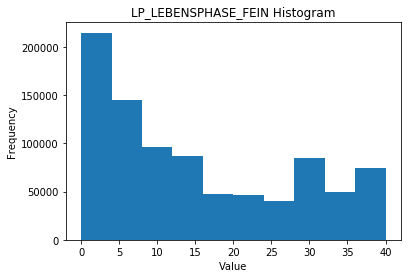

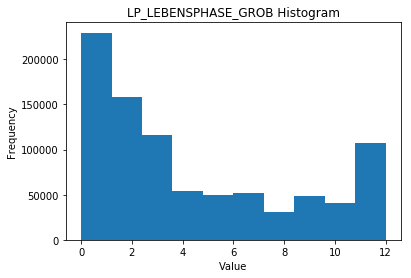

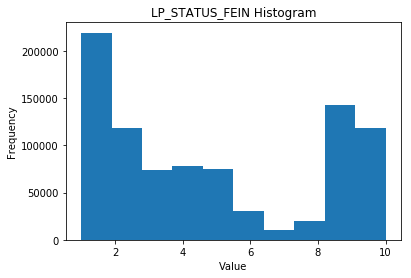

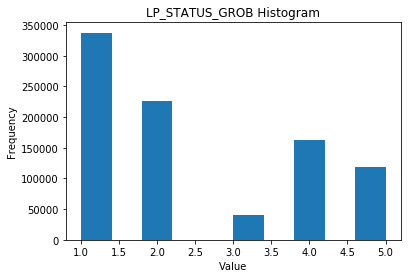

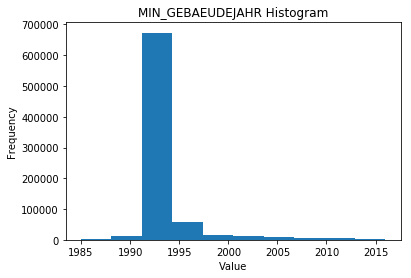

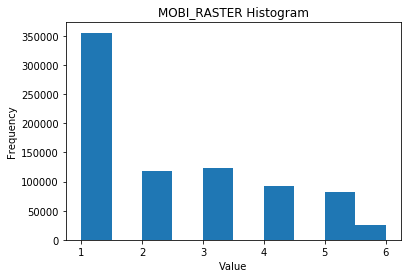

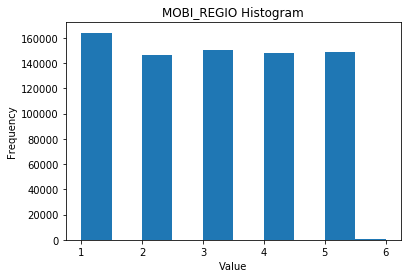

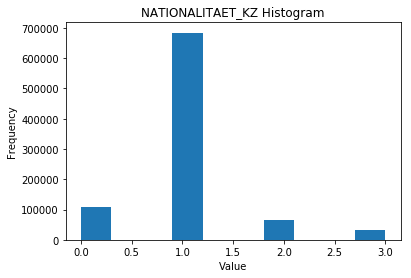

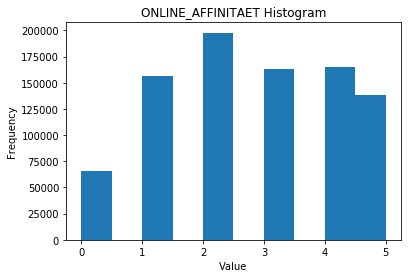

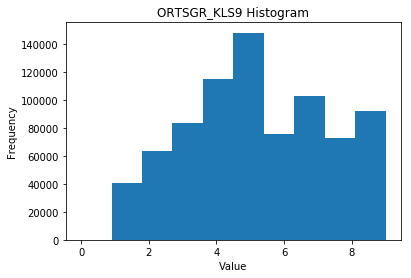

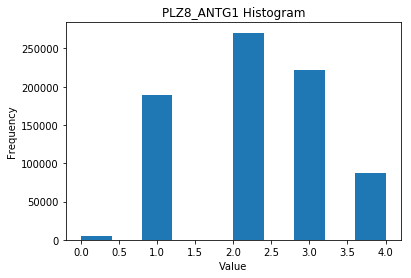

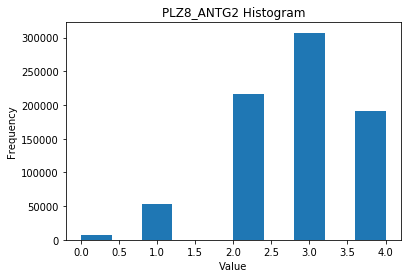

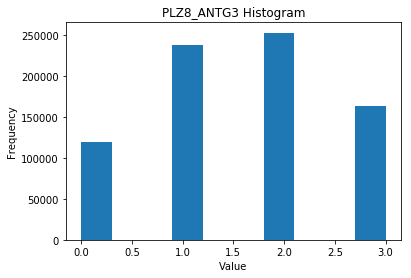

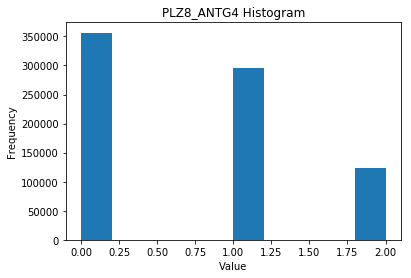

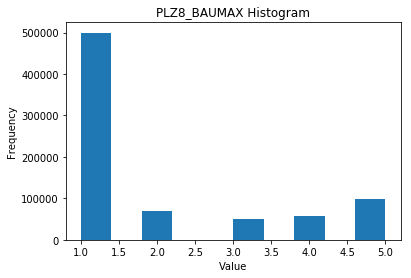

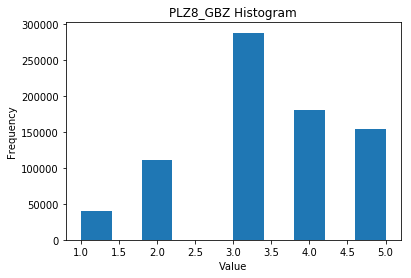

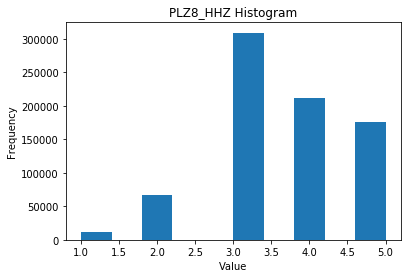

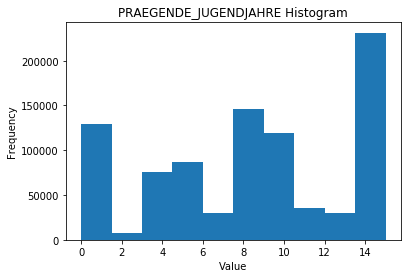

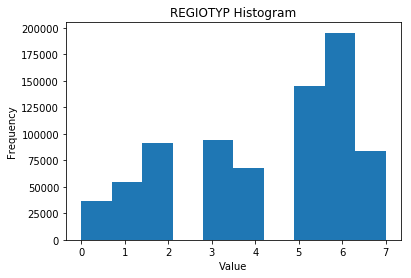

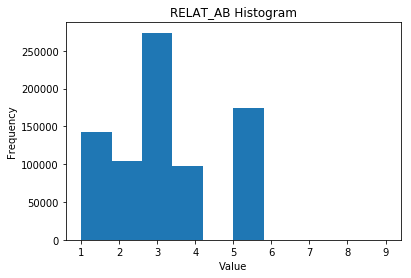

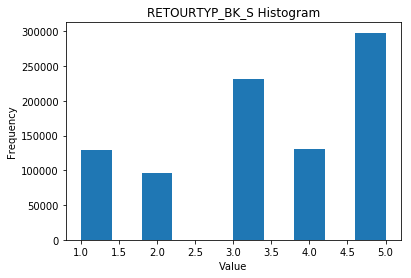

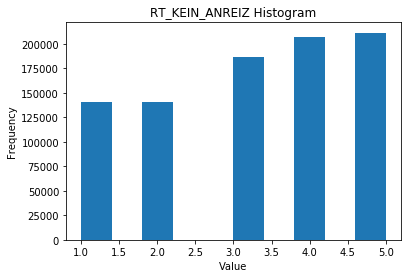

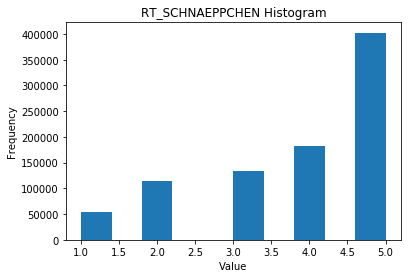

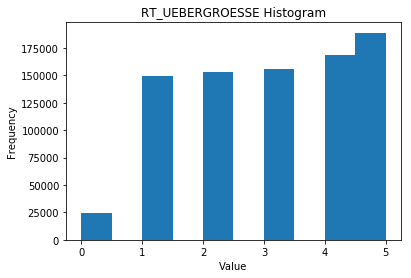

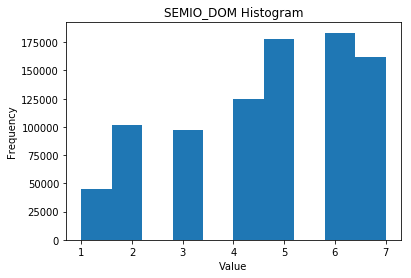

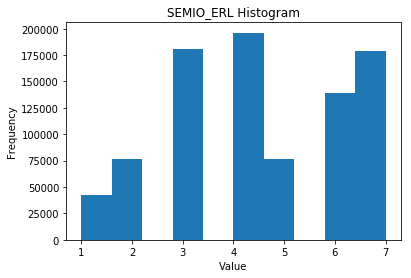

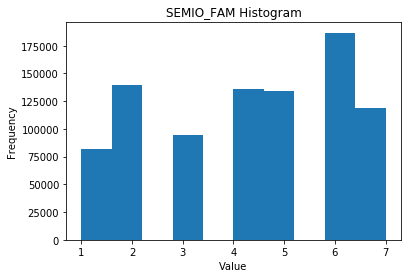

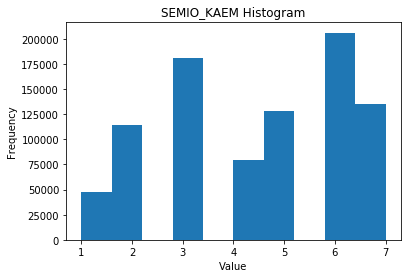

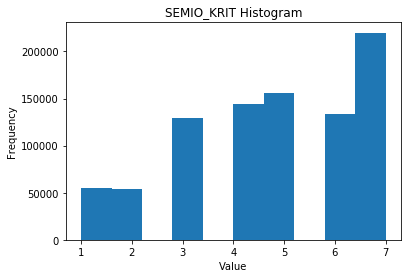

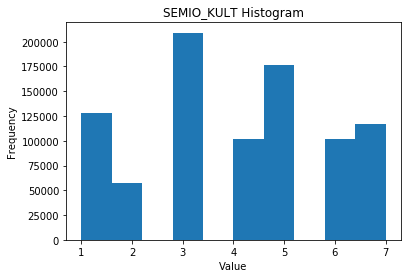

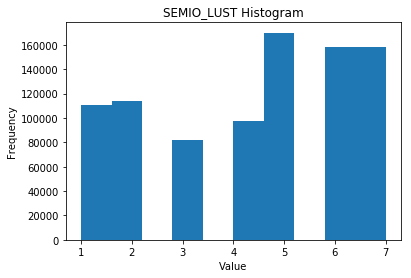

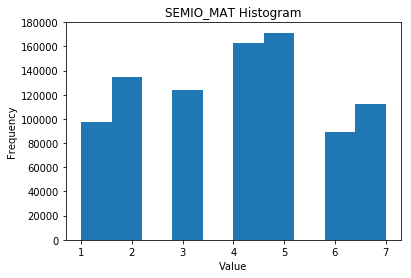

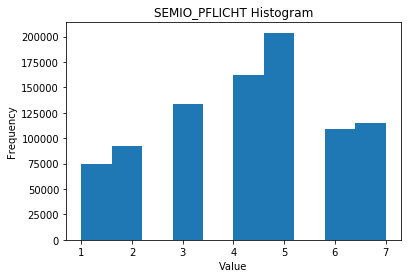

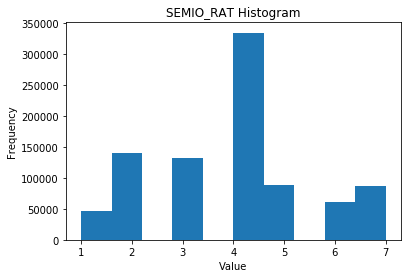

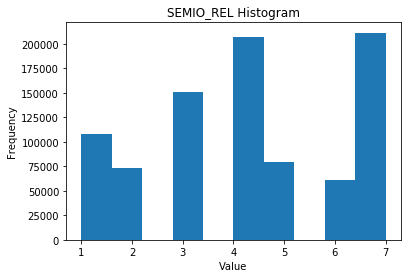

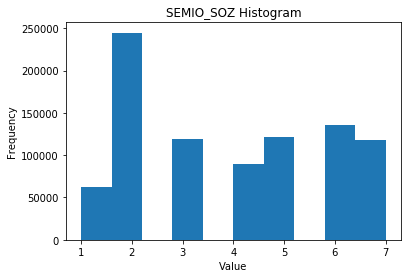

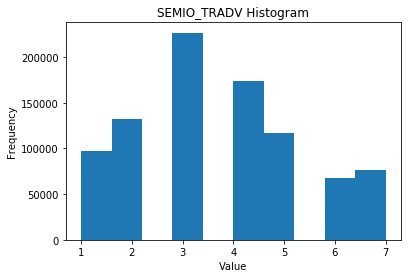

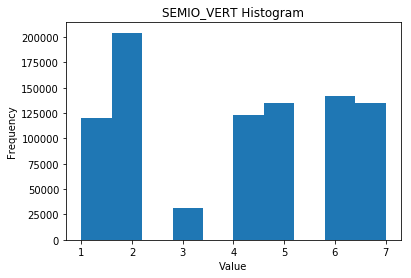

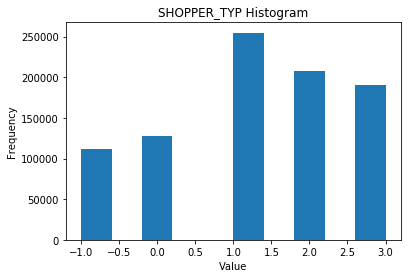

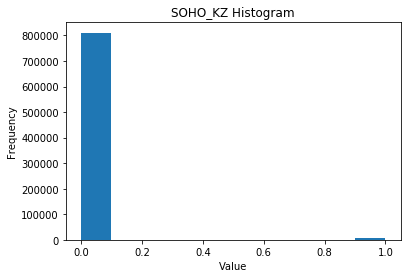

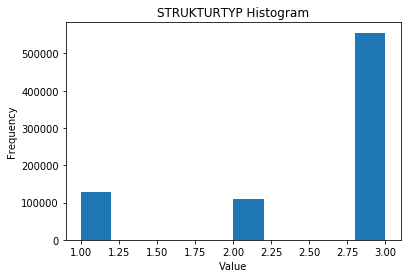

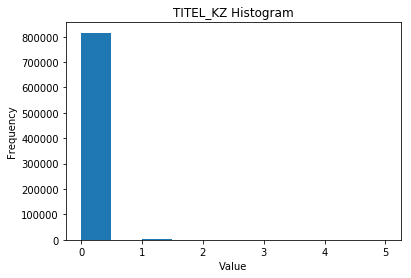

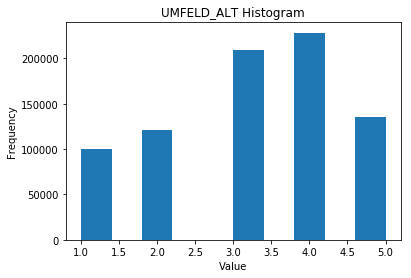

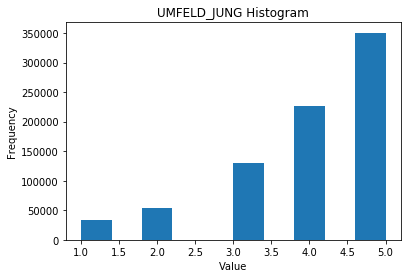

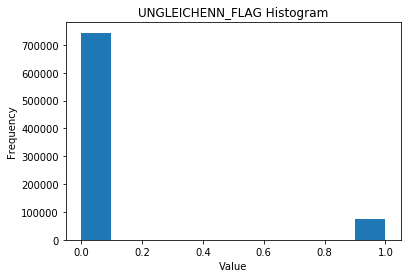

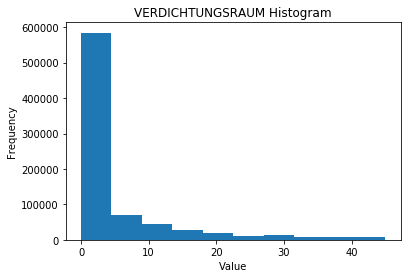

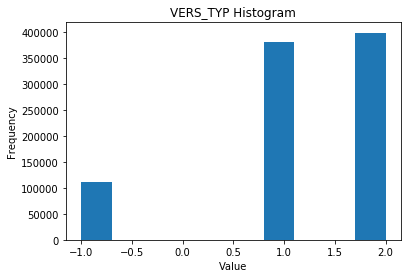

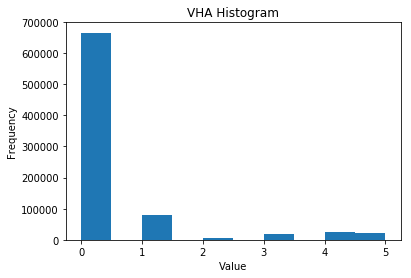

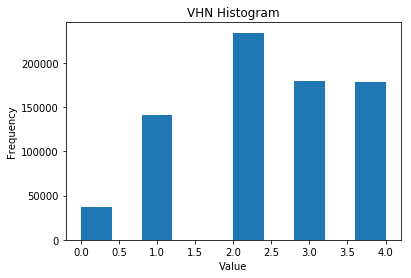

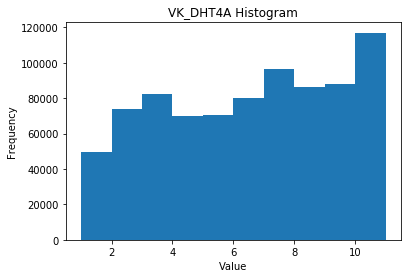

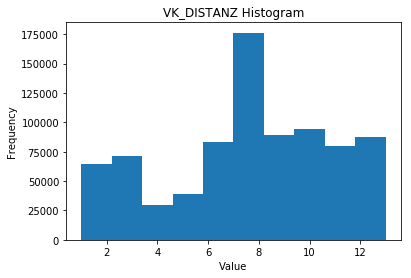

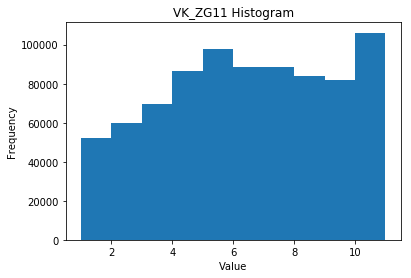

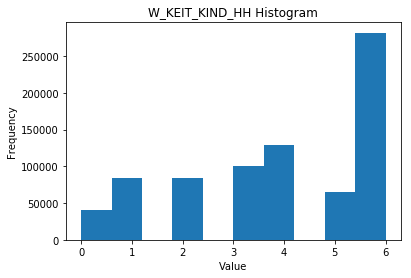

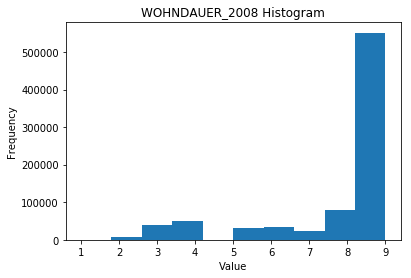

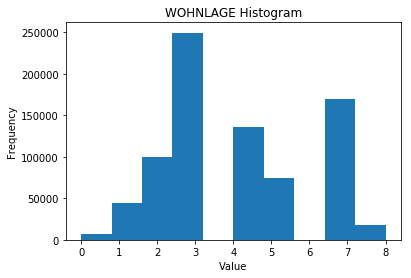

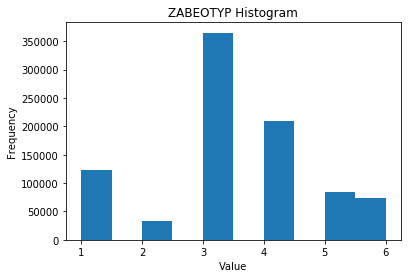

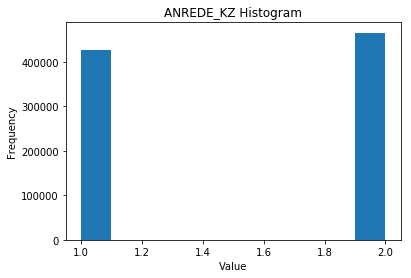

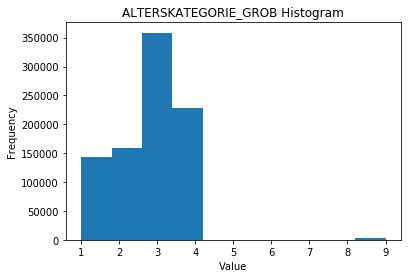

In [95]:
for column in numeric_columns:
    plt.figure()  # Create a new figure for each histogram
    azdias[column].plot.hist(bins=10)  # Adjust the number of bins as needed
    plt.title(column + " Histogram")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

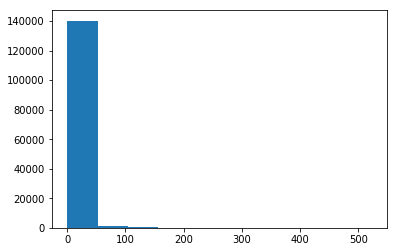

In [76]:
#check outliers
plt.hist(customers['ANZ_HAUSHALTE_AKTIV'])
plt.show()

In [22]:
#check categorical variables

In [23]:
object_columns = azdias.select_dtypes(include='object').columns
object_columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [24]:
object_columns = customers.select_dtypes(include='object').columns
object_columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

In [27]:
#check unique values 
customers['CAMEO_DEUG_2015'].value_counts()

2    23484
4    22064
6    18717
3    18390
1    16778
8    13049
5    11666
7    10558
9     6392
X      126
Name: CAMEO_DEUG_2015, dtype: int64

In [28]:
customers['CAMEO_INTL_2015'].value_counts()

14    19647
24    17805
41    11320
43     9634
25     9372
15     9217
51     8113
13     7683
22     7507
23     5770
34     5368
45     5288
54     4795
12     3715
55     3714
44     2832
31     2731
35     2294
32     1696
33     1574
52     1023
XX      126
Name: CAMEO_INTL_2015, dtype: int64

In [29]:
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

In [30]:
customers['EINGEFUEGT_AM'].head()

0    1992-02-12 00:00:00
1                    NaN
2    1992-02-10 00:00:00
3    1992-02-10 00:00:00
4    1992-02-12 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [31]:
customers['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             31910
D19_SONSTIGE              14540
D19_VERSICHERUNGEN        10534
D19_BUCH_CD               10038
D19_VOLLSORTIMENT          8647
D19_HAUS_DEKO              8129
D19_SCHUHE                 6317
D19_BEKLEIDUNG_GEH         5975
D19_DROGERIEARTIKEL        5528
D19_ENERGIE                4454
D19_BEKLEIDUNG_REST        4096
D19_VERSAND_REST           3619
D19_BANKEN_DIREKT          3466
D19_LEBENSMITTEL           3053
D19_TELKO_REST             2303
D19_NAHRUNGSERGAENZUNG     2253
D19_TELKO_MOBILE           2131
D19_TECHNIK                1836
D19_BANKEN_GROSS           1684
D19_FREIZEIT               1672
D19_SAMMELARTIKEL          1610
D19_RATGEBER               1519
D19_KINDERARTIKEL          1439
D19_WEIN_FEINKOST          1424
D19_BANKEN_REST            1233
D19_BIO_OEKO                808
D19_REISEN                  666
D19_DIGIT_SERV              653
D19_GARTEN                  568
D19_HANDWERK                532
D19_BILDUNG                 357
D19_TIER

In [32]:
customers['CAMEO_DEU_2015'].value_counts()

2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
8D     2206
1C     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64

In [33]:
customers['AGER_TYP'].value_counts()

-1    92107
 2    45874
 1    40382
 3     8658
 0     4631
Name: AGER_TYP, dtype: int64

In [34]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [35]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [36]:
#upload the file with columns values description
wb = load_workbook('data/DIAS Attributes - Values 2017 (1).xlsx')
ws = wb['Tabelle1']
df_values = pd.DataFrame(ws.values)
df_values.columns = df_values.iloc[1]
df_values = df_values.drop(index=[0,1])
df_values.fillna(method='ffill', inplace=True)

In [37]:
df_values.head()

1   NaN Attribute         Description Value                     Meaning
2  None  AGER_TYP  best-ager typology    -1                     unknown
3  None  AGER_TYP  best-ager typology     0  no classification possible
4  None  AGER_TYP  best-ager typology     1             passive elderly
5  None  AGER_TYP  best-ager typology     2            cultural elderly
6  None  AGER_TYP  best-ager typology     3   experience-driven elderly

In [38]:
df_values = df_values[df_values['Meaning'].notnull()]

unknown_values = df_values[df_values['Meaning'].str.contains("unknown")]

unknown_values = unknown_values[['Attribute', 'Value']].reset_index(drop=True)

columns_not_intersecting = list(set(customers.columns) ^ set(unknown_values['Attribute']))

unknown_values['Value'] = unknown_values['Value'].astype('str')
unknown_values['values_list'] = unknown_values['Value'].str.split(',').apply(lambda x: list(map(int, x)))

unknown_values.drop('Value', axis=1, inplace=True)

In [31]:
unknown_values.head()

1             Attribute values_list
0              AGER_TYP        [-1]
1  ALTERSKATEGORIE_GROB     [-1, 0]
2              ALTER_HH         [0]
3             ANREDE_KZ     [-1, 0]
4              BALLRAUM        [-1]

Findings:
1. EINGEFUEGT_AM is a date column, it should be deleted
2. Categorical columns CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015 have values "X", "XX" which should be replaced with -1. Then these columns can be converted to Numeric. 
3. Categorical columns 'PRODUCT_GROUP', 'CUSTOMER_GROUP' should be encoded with numerical values
4. For all numeric columns replace -1 values with NAN using unknown_values dataset
5. Drop columns with more than 80% of missing values
6. Drop rows with more than 70% of missing values
7. Fill in missing values with column average value.
8. Delete outliers. 

### Exploratory Data Analysis

In [32]:
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           NaN         NaN           NaN                         NaN   
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        NaN     NaN       NaN            NaN             NaN             NaN   
1        0.0     3.0       6.0             8A               8              51   
2        0.0     3.0       2.0             4C               4              24   
3        0.0     2.0       4.0             2A               2              12   
4        0.0     4.0       2.0             6B               6              43   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        1.0        1.0        5.0   
1            5.0                1.0        5.0        5.0        2.0   
2            3.0                2.0        4.0        4.0        1.0   
3            2.0                3.0        2.0        2.0        4.0   
4            5.0                3.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        3.0        1.0        1.0                  0                  0   
2        3.0        2.0        2.0                  0                  0   
3        4.0        5.0        3.0                  0                  0   
4        4.0        3.0        3.0                  3                  5   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                10                  0                 0                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 5                  1                 2                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        5   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         NaN                0                   0   
1                         NaN                0                   0   
2                         0.0                0                   0   
3                         0.0                0                   0   
4                        10.0                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0   

In [33]:
def plot_proportions(azdias, customers, col, mapping_dict):

    mapping = df_values[(df_values['Attribute']==col)][['Value', 'Meaning']]
    mapping_dict = dict(mapping.values)
    
    # Calculate the total count for 'azdias' and 'customers'
    azdias_counts = azdias[col].value_counts().reset_index()
    customers_counts = customers[col].value_counts().reset_index()

    azdias_counts['value'] = azdias_counts['index'].map(mapping_dict)
    customers_counts['value'] = customers_counts['index'].map(mapping_dict)

    # Calculate the proportions by dividing the counts by the total count
    total_azdias = azdias_counts[col].sum()
    total_customers = customers_counts[col].sum()


    azdias_proportions = azdias_counts[col] / total_azdias
    customers_proportions = customers_counts[col] / total_customers
    
    categories = azdias_counts['value']
    bar_width = 0.35
    bar_positions_azdias = np.arange(len(categories))
    bar_positions_customers = bar_positions_azdias + bar_width


    plt.figure(figsize=(10, 6))
    plt.bar(bar_positions_azdias, azdias_proportions, width=bar_width, label='azdias')
    plt.bar(bar_positions_customers, customers_proportions, width=bar_width, label='customers')
    plt.ylabel('Proportion')
    plt.title(f'Proportions of {col}')
    plt.xticks(rotation=30) 
    plt.xticks(bar_positions_azdias + bar_width / 2, categories)
    plt.legend()
    plt.show()

In [34]:
mapping = df_values[(df_values['Attribute']=='ALTERSKATEGORIE_GROB')][['Value', 'Meaning']]
mapping_dict = dict(mapping.values)

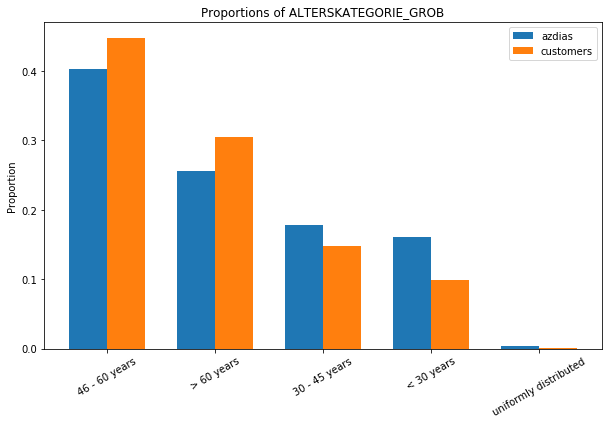

In [35]:
plot_proportions(azdias, customers, 'ALTERSKATEGORIE_GROB', mapping_dict)

In [36]:
mapping = df_values[(df_values['Attribute']=='FINANZTYP')][['Value', 'Meaning']]
mapping_dict = dict(mapping.values)

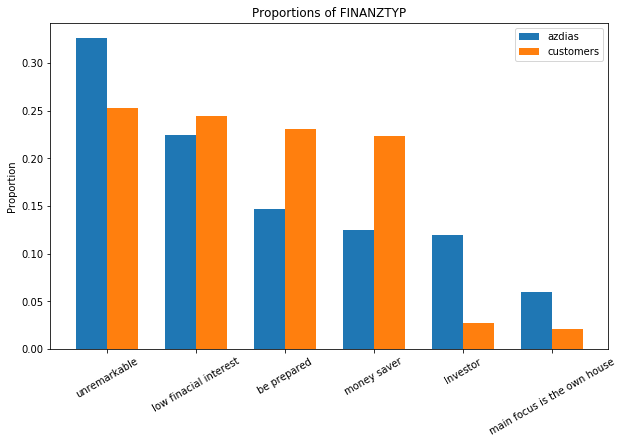

In [37]:
plot_proportions(azdias, customers, 'FINANZTYP', mapping_dict)

In [38]:
mapping = df_values[(df_values['Attribute']=='HH_EINKOMMEN_SCORE')][['Value', 'Meaning']]
mapping_dict = dict(mapping.values)

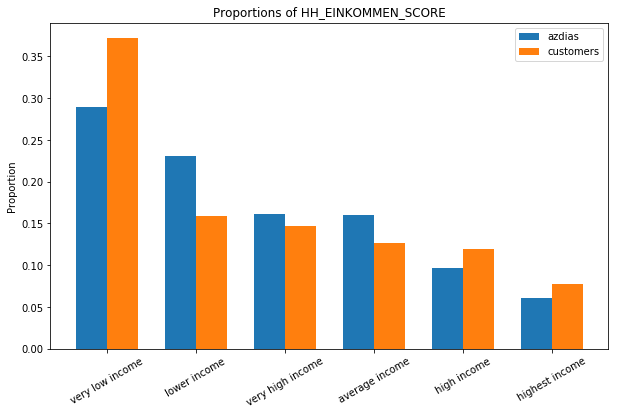

In [39]:
plot_proportions(azdias, customers, 'HH_EINKOMMEN_SCORE', mapping_dict)

In [40]:
mapping = df_values[(df_values['Attribute']=='SEMIO_DOM')][['Value', 'Meaning']]
mapping_dict = dict(mapping.values)

In [41]:
def data_agg(df, col_start, mapping_dict):
    df_col = df.loc[:, df.columns.str.startswith(col_start)]
    df_count = df_col.melt(var_name='feature', value_name='value').value_counts().reset_index(name='count')
    df_count['meaning'] = df_count['value'].map(mapping_dict)
    df_count['value_new'] = pd.concat([df_count['value'].astype('str'),
                                        df_count['meaning'].astype('str')], axis=1).apply('.'.join, axis=1)
    
    df_count = df_count.sort_values(['value_new', 'feature'])  
    
    df_count['proportion'] = df_count['count'] / df_count['count'].sum()
    
    return df_count

In [42]:
semio_azdias_count = data_agg(azdias, 'SEMIO_', mapping_dict)

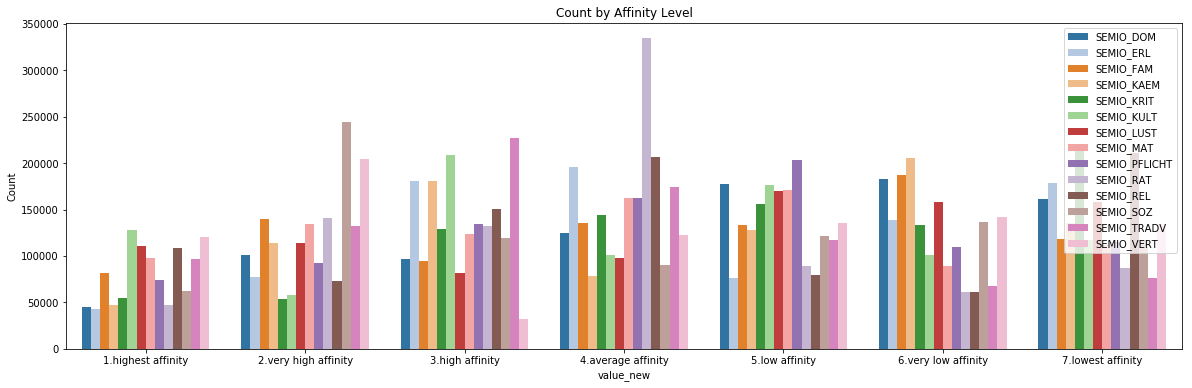

In [44]:
plt.figure(figsize=(20, 6))
colors = plt.cm.tab20(range(14))
sns.barplot(x='value_new', y='count', hue='feature', data=semio_azdias_count, palette=colors)
plt.ylabel('Count')
plt.title('Count by Affinity Level')
plt.legend(loc='upper right')
plt.show()

In [45]:
semio_cust_count = data_agg(customers, 'SEMIO_', mapping_dict)

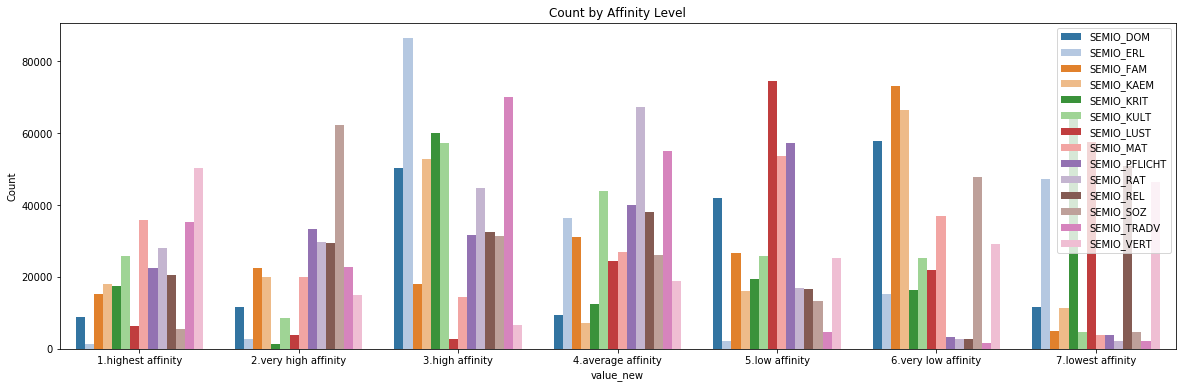

In [46]:
plt.figure(figsize=(20, 6))
colors = plt.cm.tab20(range(14))
sns.barplot(x='value_new', y='count', hue='feature', data=semio_cust_count, palette=colors)
plt.ylabel('Count')
plt.title('Count by Affinity Level')
plt.legend(loc='upper right')
plt.show()

In [47]:
mapping = df_values[(df_values['Attribute']=='FINANZ_SPARER')][['Value', 'Meaning']]
mapping_dict = dict(mapping.values)
print(mapping)

1   Value    Meaning
681    -1    unknown
682     1  very high
683     2       high
684     3    average
685     4        low
686     5   very low


In [48]:
finanz_azdias_count = data_agg(azdias, 'FINANZ_', mapping_dict)

In [52]:
finanz_cust_count = data_agg(customers, 'FINANZ_', mapping_dict)

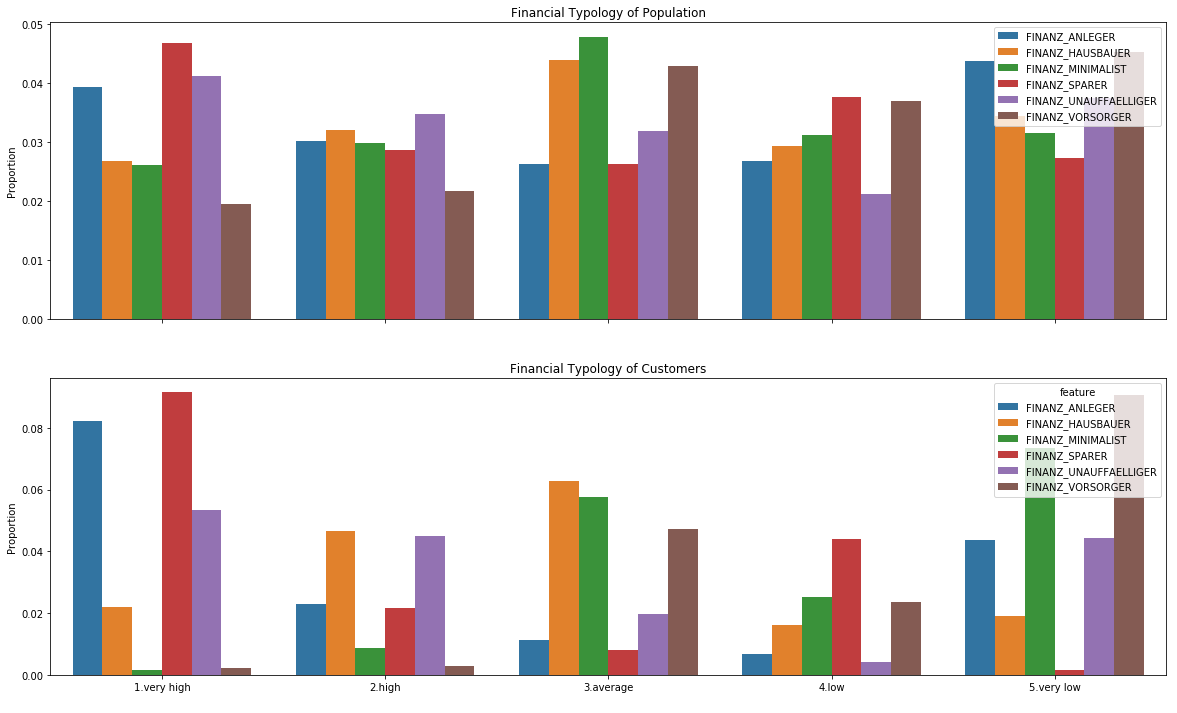

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

sns.barplot(x='value_new', y='proportion', hue='feature', data=finanz_azdias_count, ax=ax1)
ax1.set_xlabel(' ')
ax1.set_ylabel('Proportion')
ax1.set_title('Financial Typology of Population')
ax1.legend(loc='upper right')


sns.barplot(x='value_new', y='proportion', hue='feature', data=finanz_cust_count, ax=ax2)
ax2.set_xlabel(' ')
ax2.set_ylabel('Proportion')
ax2.set_title('Financial Typology of Customers');

### Data Cleaning

In [77]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    Conversion of categorical variables cat_cols into dummy variables.
    cat_cols are dropped from the dataframe (df) and a new column
    for each unique value of cat_cols is added to df.
    Args:
        df: input dataframe
        cat_cols: caregorical columns you want to create dummy variables to
        dummy_na: bool - if False NANs are ignored
    Returns:
        int: df with converted categorical variables into dummies
    '''
    for col in cat_cols:
        df = pd.concat([df.drop(col, axis=1),
                        pd.get_dummies(df[col],
                                       prefix=col,
                                       drop_first=False,
                                       dummy_na=dummy_na)],
                       axis=1)
    return df

In [78]:
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV   ANZ_HH_TITEL  \
count         628274.000000        798073.000000  794213.000000   
mean              13.700717             8.287263       0.040647   
std                5.079849            15.628087       0.324028   
min                0.000000             0.000000       0.000000   
25%               11.000000             1.000000       0.000000   
50%               14.000000             4.000000       0.000000   
75%               17.000000             9.000000       0.000000   
max               25.000000           595.000000      23.000000   

          ANZ_KINDER   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
count  817722.000000  817722.000000               798073.000000   
mean        0.154018       1.727637                    7.599356   
std         0.502389       1.155849                   14.332201   
min         0.000000       0.000000                    0.000000   
25%         0.000000       1.000000                    1.000000   
50%         0.000000       1.000000                    3.000000   
75%         0.000000       2.000000                    9.000000   
max        11.000000      45.000000                  449.000000   

           ANZ_TITEL         ARBEIT       BALLRAUM  CJT_GESAMTTYP  \
count  817722.000000  794005.000000  797481.000000  886367.000000   
mean        0.004162       3.167854       4.153043       3.632838   
std         0.068855       1.002376       2.183710       1.595021   
min         0.000000       1.000000       1.000000       1.000000   
25%         0.000000       3.000000       2.000000       2.000000   
50%         0.000000       3.000000       5.000000       4.000000   
75%         0.000000       4.000000       6.000000       5.000000   
max         6.000000       9.000000       7.000000       6.000000   

       CJT_KATALOGNUTZER      CJT_TYP_1      CJT_TYP_2      CJT_TYP_3  \
count      886367.000000  886367.000000  886367.000000  886367.000000   
mean            3.335264       3.368086       3.195014       3.351290   
std             1.493633       1.368331       1.401382       1.396508   
min             1.000000       1.000000       1.000000       1.000000   
25%             2.000000       2.000000       2.000000       2.000000   
50%             4.000000       3.000000       3.000000       3.000000   
75%             5.000000       5.000000       5.000000       5.000000   
max             5.000000       5.000000       5.000000       5.000000   

           CJT_TYP_4      CJT_TYP_5      CJT_TYP_6  D19_BANKEN_ANZ_12  \
count  886367.000000  886367.000000  886367.000000      891221.000000   
mean        3.336151       3.360684       3.465980           0.122336   
std         1.373077       1.378992       1.328456           0.535950   
min         1.000000       1.000000       1.000000     

In [85]:
def clean_data(df_orig, unknown_values):
  
    df = df_orig.copy() 
    for col in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df.loc[df[col].isin(['X','XX']),col] = -1
        df[col] = df[col].astype('float')

    common_columns = list(set(df.columns) & set(unknown_values['Attribute']))
    #replacing all coded unknown values to NaN
    for col in common_columns:
        ind = unknown_values[unknown_values.Attribute == col].index[0]
        values_list = unknown_values.loc[ind, 'values_list']
        df.loc[df[col].isin(values_list), col] = None  
     
    #delete customer_id column
    df.drop('LNR', axis=1, inplace = True)   
    
    #delete date columns    
    df.drop(['EINGEFUEGT_AM', 'GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR'], axis=1, inplace = True)   
    
    #get all categorical columns
    cat_columns = df.select_dtypes(include='object').columns  
    
    df = create_dummy_df(df, cat_columns, dummy_na=False)
    
    #missing rows percentages
    
    perc = 80.0 
    min_count =  int(((100-perc)/100)*df.shape[1] + 1)
    df.dropna(thresh=min_count, inplace=True)
        
    #missing columns percentages    
    missing_percentages = (df.isnull().sum() / len(df)) * 100
    columns_to_drop = missing_percentages[missing_percentages > 80].index
    
    df.drop(columns=columns_to_drop, inplace=True)
    
    #fill missing values with mean
    
    mean_values = df.mean()
    df.fillna(mean_values, inplace=True)
    
    #outliers
    z_scores = stats.zscore(df['ANZ_HAUSHALTE_AKTIV'])

    # Set a threshold for outlier detection (e.g., 3 standard deviations)
    threshold = 4
    

    # Find the indices of outliers
    outlier_indices = np.where(np.abs(z_scores) > threshold)[0]   
    
    df.drop(outlier_indices, inplace=True)
    
    return df

In [89]:
azdias_clean = clean_data(azdias, unknown_values)

In [91]:
azdias_clean.shape

(882734, 436)

Feature scaling to ensures all features have similar scales. The histograms of the numerical columns show that most of the festures don't follow the normal distribution, therefore MinMaxScaler is suitable to use for scaling. MinMaxScaler transforms the data by scaling it to the range between 0 and 1.

In [97]:
# create an instance of MinMaxScaler class
scaler = MinMaxScaler() 

# fit and transform the numerical columns in the DataFrame using the scaler
azdias_scaled = scaler.fit_transform(azdias_clean)

### Principal Component Analysis 

Dimensial reduction using PCA to retain most important principal components that capture the majority of the variance in the data.

In [98]:
# create an instance of PCA class with keeping all principal components (all features)
pca = PCA()
# calculation of principal components
azdias_scaled_pca = pca.fit_transform(azdias_scaled)

In [99]:
len(pca.explained_variance_ratio_)

436

In [100]:
# array with each element representing the proportion of variance explained by the corresponding principal component
explained_variance_ratio = pca.explained_variance_ratio_

In [101]:
# cumulative sum of the explained variance ratios obtained from PCA
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

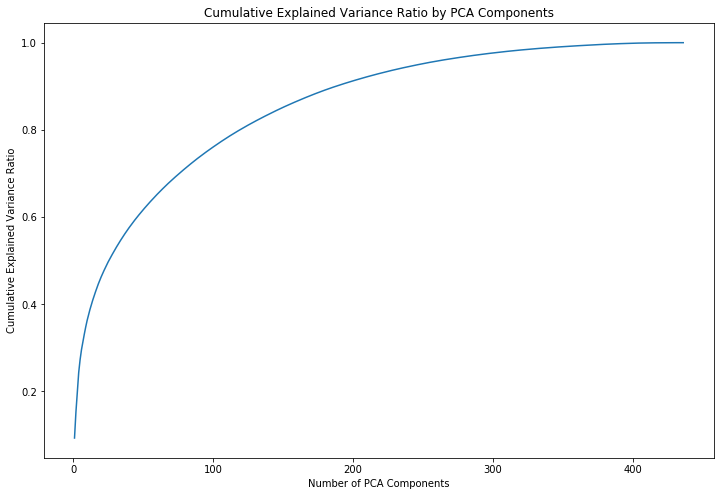

In [102]:
plt.figure(figsize=[12, 8])
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by PCA Components')
plt.show()

In [103]:
len(cumulative_variance_ratio[cumulative_variance_ratio <= 0.9])

187

We can see from the grapth that about 180 components explain 90% of the total variance. Therefore we can reduce the dimensiality of the dataset by retaining only the most important components.

In [104]:
#Keep only the top 180 principal components.
pca_187 = PCA(n_components=187)

azdias_scaled_pca_187 = pca_187.fit_transform(azdias_scaled)

In [109]:
# the weights and corresponding feature names for the first principal componen
pca_feature_map = pd.DataFrame({'weight': pca_187.components_[0],
                                'name': azdias_clean.columns})
pca_feature_map = pca_feature_map.sort_values(by='weight', ascending=False)
pca_feature_map.head()

weight               name
299  0.167874     LP_STATUS_FEIN
300  0.162481     LP_STATUS_GROB
114  0.138752        KBA05_ANTG1
94   0.125360  FINANZ_MINIMALIST
126  0.122015          KBA05_GBZ

In [110]:
# the weights and corresponding feature names for the second principal componen
pca_feature_map = pd.DataFrame({'weight': pca_187.components_[1],
                                'name': azdias_clean.columns})
pca_feature_map = pca_feature_map.sort_values(by='weight', ascending=False)
pca_feature_map.head()

weight                   name
95   0.191096          FINANZ_SPARER
17   0.184502              CJT_TYP_2
16   0.180536              CJT_TYP_1
305  0.162168      ONLINE_AFFINITAET
314  0.157543  PRAEGENDE_JUGENDJAHRE

In [111]:
# the weights and corresponding feature names for the third principal componen
pca_feature_map = pd.DataFrame({'weight': pca_187.components_[2],
                                'name': azdias_clean.columns})
pca_feature_map = pca_feature_map.sort_values(by='weight', ascending=False)
pca_feature_map.head()

weight                  name
90   0.163257              EWDICHTE
337  0.159910           STRUKTURTYP
435  0.159700         OST_WEST_KZ_W
224  0.144974  KBA13_HERST_BMW_BENZ
276  0.132044  KBA13_SEG_SPORTWAGEN

In [112]:
components_list = ['P' + str(i + 1) for i in range(187)]

In [114]:
df_pca_187 = pd.DataFrame(data = pca_187.components_,
                           columns = azdias_clean.columns,
             index = components_list
                          )
df_pca_187.head(10)

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
P1  -0.004341   -0.112973  0.008171             -0.006480   
P2   0.004423    0.009324  0.073959              0.079781   
P3   0.003109   -0.050269 -0.016560             -0.020427   
P4  -0.000965   -0.125515 -0.030225             -0.037527   
P5   0.000406    0.004575  0.007617              0.006369   
P6   0.001874    0.005804  0.002738              0.010221   
P7   0.000739    0.065230  0.027916              0.014390   
P8  -0.005194    0.001959  0.005628             -0.005017   
P9   0.001092    0.039094 -0.004623              0.006127   
P10 -0.002059   -0.006212 -0.011213             -0.002918   

     ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
P1             -0.044148     -0.000731    0.005125      0.007070   
P2              0.009417     -0.000060    0.010066      0.005307   
P3              0.016832      0.001266   -0.000753      0.001092   
P4              0.020276      0.000190   -0.000788      0.003467   
P5             -0.002522      0.000011   -0.001715      0.000348   
P6             -0.001355      0.000788   -0.000275     -0.000445   
P7             -0.009329     -0.000276    0.005114      0.008772   
P8              0.015430      0.000443    0.001918      0.002343   
P9              0.022896      0.000010   -0.001223     -0.002479   
P10             0.009424     -0.000747   -0.002043     -0.004192   

     ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
P1                    -0.018149   0.000111 -0.031255  0.069265   
P2                     0.003108  -0.000152  0.007450 -0.029734   
P3                     0.006685   0.000484 -0.001182 -0.138440   
P4                     0.008690   0.000046  0.038858 -0.017200   
P5                    -0.001376   0.000101 -0.000385 -0.004844   
P6                     0.000023   0.000331  0.037674  0.001783   
P7                    -0.004041   0.000190  0.019774 -0.031380   
P8                     0.006105   0.000043 -0.021903  0.068264   
P9                     0.010006  -0.000278 -0.013121  0.071155   
P10                    0.003930  -0.000446  0.016084 -0.018009   

     CAMEO_DEUG_2015  CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  \
P1         -0.119439        -0.093576      -0.012543          -0.052057   
P2          0.032817         0.020749       0.090206          -0.169927   
P3          0.001828         0.000557      -0.018987          -0.001375   
P4          0.072993         0.063317      -0.055365           0.037078   
P5          0.006761         0.002092       0.001929           0.150017   
P6         -0.056602        -0.036836       0.044960           0.007818   
P7         -0.009677        -0.005753      -0.062412          -0.151926   
P8          0.040434         0.019379      -0.028948          -0.009983   
P9          0.025159         0.026559      -0.070359          -0.028979   
P10         0.023025         0.025953       0.003558           0.018091   

     CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  \
P1   -0.052462  -0.075474   0.052304   0.012446   0.052759   0.030080   
P2    0.180536   0.184502  -0.178505  -0.178195  -0.180969  -0.170395   
P3   -0.059566  -0.043870   0.003579   0.027892   0.027191   0.015945   
P4   -0.138562  -0.134713   0.085472   0.067199   0.079485   0.070716   
P5   -0.054907   0.002179   0.004837  -0.036431  -0.035056   0.072310   
P6    0.042015   0.046475   0.002516   0.004947   0.007909   0.014220   
P7    0.014603  -0.001802  -0.166981  -0.120575  -0.129815  -0.125690   
P8   -0.018397  -0.036251   0.017314  -0.006476   0.008290  -0.001297   
P9   -0.034727  -0.040407  -0.031372  -0.057224  -0.064673  -0.032769   
P10  -0.015509  -0.005874   0.009593   0.018446  -0.014118   0.009282   

     D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  \
P1            0.010556           0.017735         -0.035008   
P2            0.017600           0.029724         -0.056044   
P3            0.004437           0.007

### Determining the optomal number of clusters

In [119]:
# calculate the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters. 
# The WCSS is a metric that measures the compactness of the clusters in k-means clustering
wcss = []
for i in tqdm(range(1,21)):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(azdias_scaled_pca_187)
    wcss.append(kmeans_pca.inertia_)

100%|██████████| 20/20 [1:04:39<00:00, 193.97s/it]


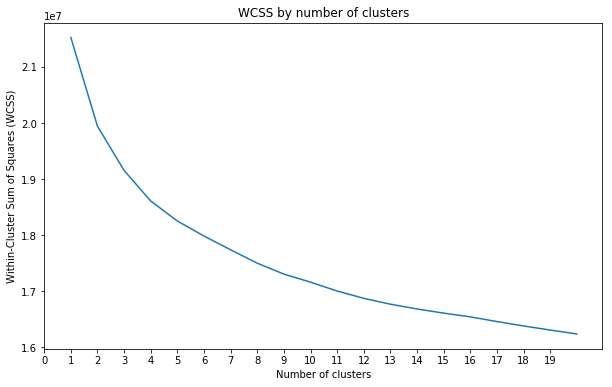

In [120]:
plt.figure(figsize=[10, 6])
plt.plot(range(1,21), wcss)
plt.xticks(np.arange(0, 20, 1))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('WCSS by number of clusters')
plt.show()

We can see from the plot that the elbow point, where the addition of more clusters does not significantly improve the WCSS, is between 4 and 11 clusters. We can use the silhouette_scores to further evaluate the optimum number of clusters.

In [122]:
# computing silhouette scores

k_values = range(3, 10)
silhouette_scores = []
kmeans_results = [] 

for k in tqdm(k_values):
    
    # Initialize the KMeans clustering model
    
    km = KMeans(n_clusters = k, random_state = 123)
    # Fit the model on the PCA-transformed data
    km.fit(azdias_scaled_pca_187)
    
    #store KMeans model for each cluster in kmeans_results
    kmeans_results.append(km) 
    
    # Predict the cluster labels for the data
    labels = km.labels_
    
     # Calculate the silhouette score
    score = silhouette_score(azdias_scaled_pca_187, labels)
    
    # Append the score to the list
    silhouette_scores.append(score)

100%|██████████| 7/7 [38:24:26<00:00, 19752.36s/it]   


In [123]:
silhouette_series = pd.Series(silhouette_scores, index = k_values)

In [133]:
silhouette_scores

[0.056992820721112225,
 0.036481601823240846,
 0.03845854120269079,
 -0.045863766381910955,
 -0.041046253768163864,
 -0.038759336965633724,
 -0.03373030712722756]

In [134]:
kmeans_results

[0, 1, 2]

In [ ]:
plt.figure(figsize=[10, 6])
plt.plot(silhouette_series)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score by number of clusters')
plt.show()

The optimal number of clusters can be chosen based on the highest silhouette score. The plot shows that the maximum silhouette score is between 4 and 6 clusters

In [135]:
# a list containing the results of the KMeans clustering algorithm
kmeans_model = KMeans(n_clusters = 5, init = 'k-means++', random_state = 123)

In [137]:
kmeans_model.fit(azdias_scaled_pca_187)

KMeans(n_clusters=5, random_state=123)

In [139]:
# store the model into the pickle file
with open('data/kmeans_model_n5.pkl', 'wb') as file:
    pickle.dump(kmeans_model, file)

### Applying clustering to general population

In [141]:
# predict the cluster labels using 5 clusters 
kmeans_pred = kmeans_model.predict(azdias_scaled_pca_187)

In [172]:
new_xtick_labels = list(range(1, 6))

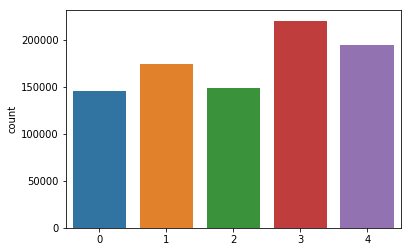

In [174]:
sns.countplot(kmeans_pred)
plt.show()

In [150]:
# assign the clusters to the original dataset
azdias_clean['kmeans_cluster'] = kmeans_model.labels_

In [151]:
azdias_clean.head()

AGER_TYP  AKT_DAT_KL   ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0  1.675376    4.421928  15.291805             13.700717             8.287263   
1  1.675376    9.000000  15.291805             21.000000            11.000000   
2  1.675376    9.000000  17.000000             17.000000            10.000000   
3  2.000000    1.000000  13.000000             13.000000             1.000000   
4  1.675376    1.000000  20.000000             14.000000             3.000000   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0      0.040647    0.154018      1.727637                    7.599356   
1      0.000000    0.000000      2.000000                   12.000000   
2      0.000000    0.000000      1.000000                    7.000000   
3      0.000000    0.000000      0.000000                    2.000000   
4      0.000000    0.000000      4.000000                    3.000000   

   ANZ_TITEL    ARBEIT  BALLRAUM  CAMEO_DEUG_2015  CAMEO_INTL_2015  \
0   0.004162  3.167854  4.153043         5.537665        35.476828   
1   0.000000  3.000000  6.000000         8.000000        51.000000   
2   0.000000  3.000000  2.000000         4.000000        24.000000   
3   0.000000  2.000000  4.000000         2.000000        12.000000   
4   0.000000  4.000000  2.000000         6.000000        43.000000   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        1.0        1.0        5.0   
1            5.0                1.0        5.0        5.0        2.0   
2            3.0                2.0        4.0        4.0        1.0   
3            2.0                3.0        2.0        2.0        4.0   
4            5.0                3.0        3.0        3.0        3.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        3.0        1.0        1.0                  0                  0   
2        3.0        2.0        2.0                  0                  0   
3        4.0        5.0        3.0                  0                  0   
4        4.0        3.0        3.0                  3                  5   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                10                  0                 0                 0   
2                10                  0                 0                 0   
3                10                  0                 0                 0   
4                 5                  1                 2                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                       10   
3                        10                       10   
4                        10                        5   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                    0.705221                0                   0   
1                    0.705221                0                   0   
2                    0.000000                0                   0   
3                    0.000000                0                   0   
4                   10.000000                6                   6   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0            0             0            0   
1                    0            0             0            0   
2                    0            6             0            0   
3                    0            0             0            6   
4                    1            6             0            6   

   D19_DIGIT_SERV  D19_DROGERIEARTIKEL  D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  \
0               0                    0            0          

In [152]:
azdias_mean = pd.DataFrame(azdias_clean.mean()).T

In [153]:
cluster_means = azdias_clean.groupby('kmeans_cluster').mean()

In [154]:
azdias_mean

AGER_TYP  AKT_DAT_KL   ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0  1.675224    4.409511  15.299214             13.705404             7.251628   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0      0.032971    0.154932      1.730802                    6.659658   

   ANZ_TITEL    ARBEIT  BALLRAUM  CAMEO_DEUG_2015  CAMEO_INTL_2015  \
0   0.004159  3.164479  4.167088          5.51112        35.335747   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0       3.634293            3.33037    3.36933   3.193796   3.353251   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0   3.334859   3.363128   3.467291           0.122814           0.220819   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0          9.264718           0.895775          0.570083          0.107523   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                  9.926388                  9.43695   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                    0.706566         0.427482            0.470545   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0             1.150838     0.488061      0.259557     1.591701   

   D19_DIGIT_SERV  D19_DROGERIEARTIKEL  D19_ENERGIE  D19_FREIZEIT  D19_GARTEN  \
0        0.197584             0.676646     0.348231      0.594051    0.257643   

   D19_GESAMT_ANZ_12  D19_GESAMT_ANZ_24  D19_GESAMT_DATUM  \
0           0.801539           1.245747          7.060995   

   D19_GESAMT_OFFLINE_DATUM  D19_GESAMT_ONLINE_DATUM  \
0                  9.030805                 7.670714   

   D19_GESAMT_ONLINE_QUOTE_12  D19_HANDWERK  D19_HAUS_DEKO  D19_KINDERARTIKEL  \
0                     3.56905      0.845587       1.023615           0.875888   

   D19_KONSUMTYP  D19_KONSUMTYP_MAX  D19_KOSMETIK  D19_LEBENSMITTEL  \
0       5.417023           5.838871      1.034178           0.32097   

   D19_LOTTO  D19_NAHRUNGSERGAENZUNG  D19_RATGEBER  D19_REISEN  \
0   1.523997                0.245862      0.505789    1.052932   

   D19_SAMMELARTIKEL  D19_SCHUHE  D19_SONSTIGE  D19_SOZIALES  D19_TECHNIK  \
0           0.597231    0.513501      2.371627      0.658972     1.744638   

   D19_TELKO_ANZ_12  D19_TELKO_ANZ_24  D19_TELKO_DATUM  D19_TELKO_MOBILE  \
0          0.049161          0.098974         9.427438          1.012051   

   D19_TELKO_OFFLINE_DATUM  D19_TELKO_ONLINE_DATUM  D19_TELKO_ONLINE_QUOTE_12  \
0                 9.827349                9.981741                   0.012278   

   D19_TELKO_REST  D19_TIERARTIKEL  D19_VERSAND_ANZ_12  D19_VERSAND_ANZ_24  \
0        0.782358          0.24448            0.607809            0.963577   

   D19_VERSAND_DATUM  D19_VERSAND_OFFLINE_DATUM  D19_VERSAND_ONLINE_DATUM  \
0           7.707569                   9.323616                  7.933345   

   D19_VERSAND_ONLINE_QUOTE_12  D19_VERSAND_REST  D19_VERSI_ANZ_12  \
0                     3.252123           0.83324          0.114238   

   D19_VERSI_ANZ_24  D19_VERSI_DATUM  D19_VERSI_OFFLINE_DATUM  \
0          0.208064         9.138243                  9.92231   

   D19_VERSI_ONLINE_DATUM  D19_VERSI_ONLINE_QUOTE_12  D19_VERSICHERUNGEN  \
0                9.976653                    0.02531            1.265509   

   D19_VOLLSORTIMENT  D19_WEIN_FEINKOST  DSL_FLAG  EWDICHTE  EXTSEL992  \
0           1.734448           0.379297  0.967609  3.925434  33.340375   

   FINANZ_ANLEGER  FINANZ_HAUSBAUER  FINANZ_MINIMALIST  FINANZ_SPARER  \
0        3.037726          3.064622           3.083624       2.820921   

   FINANZ_UNAUFFAELLIGER  FINANZ_VORSORGER  FINANZTYP  FIRMENDICHTE  \
0               2.881567          3.399553   3.788751      3.462716   

   GEBAEUDETYP  GEBAEUDETYP_RASTER  GEMEINDETYP  GFK_URLAUBERTYP  \
0     2.789107            3.748734    24.277131         7.346899   

   GREEN_AVANTGARDE  HEALTH_TYP  HH_DELTA_FLAG  HH_EINKOMMEN_SCORE  \
0          0.19802

In [156]:
new_index = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5']
cluster_means.index = new_index

In [157]:
cluster_means

AGER_TYP  AKT_DAT_KL   ALTER_HH  ALTERSKATEGORIE_FEIN  \
cluster 1  1.692082    5.763205  16.629386             15.926470   
cluster 2  1.630737    3.164904  13.323913             10.848948   
cluster 3  1.701979    4.437591  12.870558             11.086270   
cluster 4  1.680694    5.993593  16.044337             14.911245   
cluster 5  1.675842    2.699138  17.080657             15.233875   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
cluster 1            14.379030      0.063104    0.145685      1.427443   
cluster 2             2.353336      0.014046    0.049994      1.634948   
cluster 3            12.465884      0.061150    0.015265      1.325341   
cluster 4             6.648492      0.026729    0.127797      1.467688   
cluster 5             3.019754      0.012988    0.392786      2.649476   

           ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
cluster 1                   12.812945   0.002498  3.723417  2.861764   
cluster 2                    2.250871   0.005979  2.790542  4.796331   
cluster 3                   11.702329   0.004724  3.655170  3.615254   
cluster 4                    6.107736   0.002915  3.035588  4.481027   
cluster 5                    2.790051   0.004745  2.853443  4.644302   

           CAMEO_DEUG_2015  CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  \
cluster 1         7.781345        46.803615       3.980372           2.947211   
cluster 2         3.942896        26.737290       2.647883           3.992359   
cluster 3         7.157121        45.473531       2.872549           4.248010   
cluster 4         5.300305        34.215048       4.363259           3.387675   
cluster 5         4.202812        28.005748       4.014085           2.260367   

           CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  \
cluster 1   4.333818   4.385634   2.016542   2.390868   2.081034   2.450646   
cluster 2   2.129431   1.837476   4.297591   4.214312   4.366797   4.385766   
cluster 3   2.193346   2.132106   4.134814   4.195752   4.147857   4.173418   
cluster 4   4.334190   4.156099   3.126162   3.140565   3.055577   3.271147   
cluster 5   3.563086   3.237738   3.167856   2.816805   3.172500   3.088610   

           D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  \
cluster 1           0.122677           0.226983          9.213766   
cluster 2           0.034641           0.079264          9.641312   
cluster 3           0.032045           0.066699          9.707285   
cluster 4           0.012607           0.033084          9.837521   
cluster 5           0.395555           0.672535          7.981003   

           D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
cluster 1           1.010238          0.694408          0.036865   
cluster 2           0.531146          0.320366          0.108523   
cluster 3           0.436007          0.274654          0.037343   
cluster 4           0.328672          0.209133          0.030082   
cluster 5           2.128049          1.333885          0.300425   

           D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
cluster 1                  9.941249                 9.389216   
cluster 2                  9.972751                 9.754717   
cluster 3                  9.982356                 9.797928   
cluster 4                  9.989614                 9.881755   
cluster 5                  9.759689                 8.410356   

           D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
cluster 1                    0.741727         0.378104            0.281118   
cluster 2                    0.254527         0.246024            0.424771   
cluster 3                    0.337671         0.162734            0.222458   
cluster 4                    0.501331         0.105348            0.066991   
cluster 5                    1.597718         1.192631            1.298289   

           D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
cluster 1 

Now we can compare the mean values in each cluster agains the total mean values to see how clusters differ from overall dataset.

Cluster 1: young adults 30-45 years old, average probability of children present in the household, high mobility, single high-income earners, single independent persons, living 3-5km from the city center in a high-density area, low money saver, low-consumption middle class

Cluster 2: middle age 45-60 years old, average probability of children present in the household, tradional minded,
religious, low mobility, average earners,single high-income earners couple, 10-20 km from the city centre, very high money saver, high focus on their own house, investors, consumption-oriented middle class

Cluster 3: middle age 45-60 years old, no kids, low-consumption middle class, tradional minded, religious, high mobility,  single high-income earners, wealthy single homeowners, 5-10 km from the city centre, very high money saver, investors

Cluster 4: young adults 30-45 years old, average probability of children present in the household, single average earner, consumption-oriented middle class, 5-10 km from the city centre, low money saver, active middle class

Cluster 5: young families 30-45 years old with kids, very high online affinity, average earner-families, 10-20 km from the city centre, average money savers, high focus on their own house, high online activity in the segment Mail order, consumption-oriented middle class

###  Compare customer data to general population

In [158]:
# clean the customers dataset
customers_clean = clean_data(customers, unknown_values)

In [159]:
# keep the same columns as in azdias dataset
common_columns = np.intersect1d(customers_clean.columns, azdias_clean.columns)
customers_clean = customers_clean[common_columns]

In [161]:
customers_scaled = scaler.fit_transform(customers_clean)

In [164]:
#Apply the dimensionality reduction to the customers feature matrix using the learned PCA model
customers_scaled_pca_187 = pca_187.fit_transform(customers_scaled)

In [165]:
# predict the cluster labels using 6 clusters 
customers_pred = kmeans_model.predict(customers_scaled_pca_187)

In [168]:
df_azdias_clusters = pd.DataFrame({'cluster': pd.Series(kmeans_pred)})
df_azdias_clusters['type'] = 'general_population'
df_customers_clusters = pd.DataFrame({'cluster': pd.Series(customers_pred)})
df_customers_clusters['type'] = 'customers'
df_combined = df_azdias_clusters.append(df_customers_clusters)

In [169]:
counts_per_cluster = df_combined.groupby(['type', 'cluster']).size().reset_index(name='count_per_cluster')
counts_total = df_combined.groupby('type').size().reset_index(name='total_per_type')
df_proportions = counts_per_cluster.merge(counts_total, how= 'left', on='type')
df_proportions['prop'] = df_proportions['count_per_cluster']/df_proportions['total_per_type']

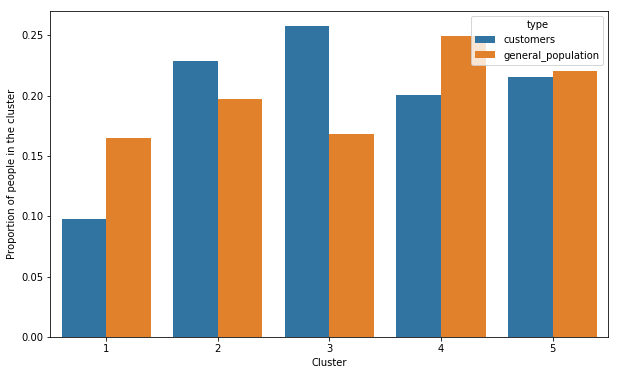

In [260]:
plt.figure(figsize=[10, 6])
ax = sns.barplot(x='cluster', y='prop', hue='type', data=df_proportions)
ax.set_xticklabels(new_xtick_labels)
plt.xlabel('Cluster')
plt.ylabel('Proportion of people in the cluster')
plt.show()

The proportion of customers belonging to cluster 2 and 3 is significantly higher relative to the general population data. These clusters have low-consumption middle class, online shopper, lowest transaction activity, low money saver, single average earner at retirement age, average income.

## Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [175]:
import pandas as pd
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';' , dtype={18:'str', 19:'str'})

In [176]:
mailout_train.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   8.0                 15.0   
1          NaN          NaN                  13.0                  1.0   
2          NaN          NaN                   7.0                  0.0   
3          NaN          NaN                   6.0                  4.0   
4          NaN          NaN                   9.0                 53.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           0.0         0.0           1.0                        13.0   
1           0.0         0.0           2.0                         1.0   
2           NaN         0.0           0.0                         1.0   
3           0.0         0.0           2.0                         4.0   
4           0.0         0.0           1.0                        44.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        0.0     3.0       5.0             5D             5.0            34.0   
1        0.0     2.0       5.0             5B             5.0            32.0   
2        0.0     4.0       1.0             2D             2.0            14.0   
3        0.0     4.0       2.0             2D             2.0            14.0   
4        0.0     3.0       4.0             7B             7.0            41.0   

   CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  \
0            2.0                5.0        2.0        2.0        5.0   
1            2.0                2.0        2.0        2.0        4.0   
2            4.0                5.0        1.0        1.0        5.0   
3            2.0                5.0        2.0        2.0        5.0   
4            6.0                5.0        1.0        2.0        5.0   

   CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  \
0        5.0        5.0        5.0                  0                  0   
1        3.0        5.0        4.0                  1                  1   
2        5.0        5.0        5.0                  0                  1   
3        5.0        5.0        4.0                  0                  0   
4        5.0        5.0        5.0                  0                  0   

   D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  D19_BANKEN_LOKAL  \
0                10                  0                 0                 0   
1                 5                  0                 0                 3   
2                 7                  0                 0                 0   
3                10                  0                 0                 0   
4                10                  0                 0                 0   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0                        10                       10   
1                        10                       10   
2                        10                        7   
3                        10                       10   
4                        10                       10   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         0.0                0                   0   
1                         0.0                0                   0   
2                         0.0                5                   0   
3                         0.0                0                   0   
4                         0.0                0                   5   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                    0            0

In [177]:
mailout_train.shape

(42962, 367)

In [178]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [184]:
mailout_train_clean = clean_data(mailout_train, unknown_values)

In [186]:
target = mailout_train_clean['RESPONSE']
mailout_train_clean.drop(columns=['RESPONSE'], inplace=True)

In [187]:
mailout_train_scaled = scaler.fit_transform(mailout_train_clean)

In [188]:
mailout_train_scaled_pca_187 = pca_187.fit_transform(mailout_train_scaled)

In [190]:
#split data into features and target
X = mailout_train_scaled_pca_187
y = target.values

In [191]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [192]:
unique_elements, counts = np.unique(y_test, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

0: 8410
1: 105


In [193]:
unique_elements, counts = np.unique(y_train, return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

0: 33635
1: 421


**Random Forest Classifier**

In [194]:
clf = RandomForestClassifier(class_weight='balanced')

In [206]:
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],       # Maximum depth of the trees
    'min_samples_split': [8, 10, 12],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [3, 4, 5]     # Minimum number of samples required to be at a leaf node
}

In [207]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

In [208]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [50, 100, 150]})

In [209]:
best_model = grid_search.best_estimator_

In [232]:
with open('data/random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [210]:
grid_search.best_params_

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 150}

In [211]:
best_model.score(X_train, y_train)

0.9580103359173127

In [212]:
best_model.score(X_test, y_test)

0.9485613623018203

In [319]:
y_pred = best_model.predict(X_test)

In [320]:
cm = confusion_matrix(y_test, y_pred)

In [321]:
rf_roc_auc = roc_auc_score(y_test, y_pred)

**Logistic Regression**

In [215]:
param_grid_log = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga']
}

In [216]:
log_clf = LogisticRegression(class_weight = 'balanced', max_iter = 1000) 

In [217]:
import warnings
warnings.filterwarnings("ignore")

In [219]:
grid_search_log = GridSearchCV(estimator=log_clf, param_grid=param_grid_log, cv=5)
grid_search_log.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [220]:
best_model_log = grid_search_log.best_estimator_

In [231]:
with open('data/logreg_model.pkl', 'wb') as file:
    pickle.dump(best_model_log, file)

In [221]:
grid_search_log.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [323]:
y_pred_log = best_model_log.predict(X_test)

In [324]:
cm_log = confusion_matrix(y_test, y_pred_log)

In [325]:
log_roc_auc = roc_auc_score(y_test, y_pred_log)

**XGBoost**

In [237]:
xgb_clf = xgb.XGBClassifier(scale_pos_weight=8)

In [245]:
param_grid = {
    'n_estimators': [100, 200, 300],
    #'learning_rate': [0.1], #, 0.01, 0.001],
    'max_depth': [3, 4, 5],
    #'subsample': [0.8], #, 0.9, 1.0],
    #'colsample_bytree': [0.8], #, 0.9, 1.0],
    #'reg_alpha': [0.1], #[0, 0.1, 0.5],
    #'reg_lambda': [0.1], #[0, 0.1, 0.5],
}

In [246]:
grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, verbose=10, scoring='roc_auc')
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 1/5; 1/9] END max_depth=3, n_estimators=100;, score=0.602 total time=  30.2s
[CV 2/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 2/5; 1/9] END max_depth=3, n_estimators=100;, score=0.566 total time=  33.4s
[CV 3/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 3/5; 1/9] END max_depth=3, n_estimators=100;, score=0.612 total time=  31.9s
[CV 4/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 4/5; 1/9] END max_depth=3, n_estimators=100;, score=0.633 total time=  30.2s
[CV 5/5; 1/9] START max_depth=3, n_estimators=100...............................
[CV 5/5; 1/9] END max_depth=3, n_estimators=100;, score=0.584 total time=  29.3s
[CV 1/5; 2/9] START max_depth=3, n_estimators=200...............................
[CV 1/5; 2/9] END max_depth=3, n_estimators=200;,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [241]:
grid_search_xgb

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

In [247]:
best_model_xgb = grid_search_xgb.best_estimator_

In [326]:
y_pred_xgb = best_model_xgb.predict(X_test)

In [327]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

In [328]:
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)

In [329]:
confusion_matrix(["1", "1", "1", "0", "0"], ["0", "0", "1", "1", "0"], labels=["1", "0"])

array([[1, 2],
       [1, 1]])

In [330]:
def accuracy(_confusion_matrix):
    return (_confusion_matrix[0][0] + _confusion_matrix[1][1]) / np.sum(_confusion_matrix)

In [331]:
df_summary = pd.DataFrame([
    {
        'name': 'RandomForestClassifier',
        'true positive': cm[0][0],
        'false positive': cm[1][0],
        'true negative': cm[1][1],
        'false negative': cm[0][1],
        'accuracy': accuracy(cm),
        'ROC AUC': rf_roc_auc
    },
    {
        'name': 'LogisticRegression',
        'true positive': cm_log[0][0],
        'false positive': cm_log[1][0],
        'true negative': cm_log[1][1],
        'false negative': cm_log[0][1],
        'accuracy': accuracy(cm_log),
        'ROC AUC': log_roc_auc
    },
    {
        'name': 'XGBoostClassifier',
        'true positive': cm_xgb[0][0],
        'false positive': cm_xgb[1][0],
        'true negative': cm_xgb[1][1],
        'false negative': cm_xgb[0][1],
        'accuracy': accuracy(cm_xgb),
        'ROC AUC': xgb_roc_auc
    }
])


df_summary = df_summary.set_index('name')
df_summary

true positive  false positive  true negative  \
name                                                                   
RandomForestClassifier           8073             101              4   
LogisticRegression               5913              46             59   
XGBoostClassifier                8406             105              0   

                        false negative  accuracy   ROC AUC  
name                                                        
RandomForestClassifier             337  0.948561  0.499012  
LogisticRegression                2497  0.701351  0.632498  
XGBoostClassifier                    4  0.987199  0.499762

In [332]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [333]:
from tabulate import tabulate
tabulate(df_summary, headers='keys', tablefmt='psql')

'+------------------------+-----------------+------------------+-----------------+------------------+------------+-----------+\n| name                   |   true positive |   false positive |   true negative |   false negative |   accuracy |   ROC AUC |\n|------------------------+-----------------+------------------+-----------------+------------------+------------+-----------|\n| RandomForestClassifier |            8073 |              101 |               4 |              337 |   0.948561 |  0.499012 |\n| LogisticRegression     |            5913 |               46 |              59 |             2497 |   0.701351 |  0.632498 |\n| XGBoostClassifier      |            8406 |              105 |               0 |                4 |   0.987199 |  0.499762 |\n+------------------------+-----------------+------------------+-----------------+------------------+------------+-----------+'

**Models evaluation**

Start
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
[learning_curve] Training set sizes: [  500  3000  5448 13622 27244]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  4.9min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   solver='liblinear')
[learning_curve] Training set sizes: [  500  3000  5448 13622 27244]


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    9.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=150)
[learning_curve] Training set sizes: [  500  3000  5448 13622 27244]


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  2.4min finished


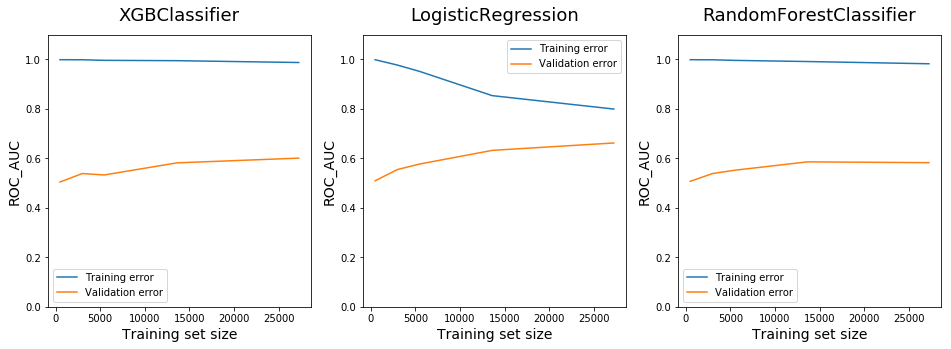

In [254]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

scores = []

### Bundling our previous work into a function ###
def learning_curves(estimator, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, X_train, y_train, train_sizes =
    train_sizes,
    cv = cv, scoring = 'roc_auc', n_jobs=2, verbose=1)
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
#     print(train_scores_mean, validation_scores_mean)
    title = str(estimator).split('(')[0]
    scores.append({'title': title, 'validation': validation_scores_mean[-1], 'train': train_scores_mean[-1]})
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('ROC_AUC', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    
    max_y = max(np.max(train_scores_mean), np.max(validation_scores_mean))
    plt.ylim(0,max_y + max_y * 0.1)

### Plotting the learning curves ###

plt.figure(figsize = (16,5))

train_sizes = [500, 3000, int(27244/5), int(27244/2), 27244]
print("Start")

# estimators = [LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l2',
#                                                  solver='liblinear'), 
#                           RandomForestClassifier(class_weight='balanced', max_depth=10, min_samples_leaf=4,
#                                                  min_samples_split=10, n_estimators=150),
#                           best_model_xgb]
estimators = [best_model_xgb,
              best_model_log,
              best_model]
for i, model in enumerate(estimators):
    print(model)
    plt.subplot(1,len(estimators),i + 1)
    learning_curves(model, train_sizes, cv=5)

**Prediction on the new data**

In [255]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';' , dtype={18:'str', 19:'str'})

In [256]:
mailout_test_clean = clean_data(mailout_test, unknown_values)

In [257]:
mailout_test_scaled = scaler.fit_transform(mailout_test_clean)

In [258]:
mailout_test_scaled_pca_187 = pca_187.fit_transform(mailout_test_scaled)

In [259]:
y_test_pred = best_model_log.predict(mailout_test_scaled_pca_187)

### Further improvements

Additional techniques can be applied to handle imbalanced data such as :
- resampling of the training set
- oversampling 
- k-fold cross validation

Different supervised machine learning techniques can be tested such as:
- Logistic regression
- Support Vector Machines
- Decision Trees

## Conclusion

Using unsupervised learning, I split the population into 5 clusters based on the age, social-demographic status, . After that I determined in which of those clusters the customers are over or under represented. This clustering can help the company target more effectively. 

Based on data of existing responses, I was able to test Machine Learning algorithms to predict better those who are likely to respond.